# Trabajo práctico 1 : Analisis exploratorio del dataset Properatti

Grupo #11: Camila Coltriani, Irania Fuentes, Johnatan Fischelson, Luis Dartayet, Ornela Cevolli  

Para este trabajo utilizaremos un dataset de la inmobiliaría Properati construido con los datos de venta de propiedades en diferentes provincias de Argentina en el primer semestre del año 2017.

# Objectivos

El objetivo de este trabajo es realizar una limpieza del dataset properatti con la finalidad de obtener un dataset final con datos confiables que pueda ser utilizado en la generación de un modelo estadistico posterior.
Con base en esto se plantean los siguientes objetivos especificos:
 - Adquirir los datos: leer y conocer su estructura para determinar las herramientas apropiadas para su manipulación.

 - Parsear los datos: realizar el analisis exploratorio de los datos que permita verificar la existencia o no de relaciones entre variables, valores duplicados, valores faltantes, valores atípicos o valores erroneos que para validar o aumentar la confiabilidad de los datos.

 - Minar los datos: aplicar las herramientas de python para corregir datos erroneos o duplicados, completar/eliminar valores nulos.
 
 - Refinar los datos: eliminar variables redundantes o repetidas, crear nuevas variables y dar un formato limpio al dataset original.

# Adquirir y visualizar el dataset

In [1]:
#librerías utilizadas para la adquisición de los datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import geopandas as gpd
import shapely.wkt
from decimal import Decimal
import re

Otros recursos utilizados
- dataset de id_geonames: ar_copy.csv
- dataset de barrios Argentina: barrios.csv 
- dataset de municipios Argentina del IGN: municipio.shp

In [2]:
# Leemos y asignamos el dataset properatti.csv en una variable 
data = pd.read_csv("./properatti.csv", index_col=0)

In [3]:
# Visualización de la forma y atributos del dataset 
print(data.shape)
print("El dataset está compuesto por:", data.shape[0], "filas y",data.shape[1],"columnas.")
data.sample(5) #

(121220, 25)
El dataset está compuesto por: 121220 filas y 25 columnas.


,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
7501,sell,apartment,San Telmo,|Argentina|Capital Federal|San Telmo|,Argentina,Capital Federal,3428113.0,"-34.6175845,-58.3771975",-34.617584,-58.377198,...,44.0,NaN,2577.181818,NaN,1.0,NaN,http://www.properati.com.ar/15y5g_venta_depart...,Pozo • Entrega 31/10/2018Ubicado a metros del ...,Alto Grande Independencia - Edificio a estrenar,https://thumbs4.properati.com/3/qif4K_XLBQwEyD...
55238,sell,house,Talar del Lago 1,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Tala...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4407611,-58.649116",-34.440761,-58.649116,...,390.0,1239.130435,1461.538462,NaN,NaN,NaN,http://www.properati.com.ar/19opj_venta_casa_t...,TALAR DEL LAGO 2 . CASA VENTA CORREDOR BANCALA...,TALAR DEL LAGO 2 . CASA VENTA CORREDOR BANCALA...,https://thumbs4.properati.com/4/9B-3Wa_GhlQN2u...
28464,sell,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,"-32.9365328,-60.6458065",-32.936533,-60.645806,...,58.0,NaN,3431.034483,NaN,NaN,NaN,http://www.properati.com.ar/17w7d_venta_depart...,CODIGO: 2062-657 ubicado en: JUJUY 1800 - Pub...,VENTA DEPTO 2 DORMITORIOS. CON COCHERA. PILETA...,https://thumbs4.properati.com/2/rezp-n0U_ay0-o...
15314,sell,house,Mar del Plata,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3430863.0,"-38.0311175,-57.558681",-38.031118,-57.558681,...,120.0,NaN,808.333333,NaN,4.0,NaN,http://www.properati.com.ar/16urd_venta_casa_m...,"Living, cocina comedor diario, baño completo r...",Casa en Venta. Ambientes. Dormitorios. 120 m2c,https://thumbs4.properati.com/5/a4HLmFVK7ozRlG...
14089,sell,house,Berazategui,|Argentina|Bs.As. G.B.A. Zona Sur|Berazategui|,Argentina,Bs.As. G.B.A. Zona Sur,3436042.0,"-34.8131946522,-58.1778435892",-34.813195,-58.177844,...,300.0,1333.333333,1333.333333,NaN,NaN,NaN,http://www.properati.com.ar/16r39_venta_casa_b...,Alquiler temporario de Casa 5 AMBIENTES en El ...,"Casa | El Carmencito, Bo. Parque El Carmen",https://thumbs4.properati.com/7/aRyt7Gg2zTI8wr...


### Descripción de las columnas del dataset:

Los atributos o columas que incluye son:

● unmaded: 0: indice de filas

● property_type: tipo de inmueble en venta (casa, departamento, ph...)

● operation: tipo de operacion inmobiliaria para las propiedades 

● place_name: ubicacion del inmueble por ciudad/Partido o barrios

● place_with_parent_names: ubicacion agrupada del inmueble (Pais|Provincia|Partido o barrio)

● country_name: nombre del país donde ocurre la operacion inmobiliaría

● state_name: ubicacion del inmueble por provincia

● geonames_id: número de identificación en la base de datos GeoNames asociado a la ubicacion por coordenadas

● lat-lon: ubicacion de latitud y longitud concatenada

● lat  ●lon: ubicacion de latitud y longitud en columnas separadas

● price: precio del inmueble

● currency: divisa en la que está expresado el precio del inmueble

● price_aprox_local_currency: Precio aproximado en la moneda local del país de publicación

● surface_total_in_m2: superficie total m² del inmueble

● surface_covered_in_m2: Superficie cubierta en m²

● price_usd_per_m2: Precio en dolares por metro cuadrado (USD/m²: precio dólares / superficie)

● price_per_m2: Precio del metro cuadrado del inmueble

● floor: N° de piso (cuando corresponde)

● room: cantidad de habitaciones

● expenses: expensas (cuando corresponde)

● properati_url	: URL de la inmobiliaría Properati en la Web

● description: descripción del inmueble en la publicación Web

● title: título del inmueble en la publicación

● image_thumbnail: URL de un thumbnail de la primer foto en la Web

# Parsear los datos

> Hipótesis: como variables a considerar para estimar los precios de las propiedades en el modelo posterior consideramos que superficie y ubicación son las más importantes
> ___

## Analisis exploratorio general del dataset Properatti

In [4]:
#Identificamos el tipo de dato de cada columna
data.dtypes
# El tipo de datos para variables cuantitativas discreta como floor y rooms deberia ser int, 
# posiblemente tengamos que realizar el cambio en su manipulación.

operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: object

In [5]:
# Realizamos una descripción estadística de todas las columnas ("include all también muestra las variables categóricas") 
# que resume la tendencia central, la dispersión y la forma de la distribución de un conjunto de datos
data.describe(include="all")

# Algunas interpretaciones/inferencias:
# operation y country_name tiene 1 solo dato:  Sell y Argentina, como ya sabíamos, el dataset son datos de venta en Argentina
# Existen cuatro tipos de propiedades en venta, la más frecuente es apartamento
# Placename tiene como dato más frecuente la ciudad de Cordoba y state_name tiene a Capital Federal
# lat-long hay datos repetidos o son los mismos edificios representados en un area determinada
# Existen valores máximos muy alejados del resto de datos en las columnas de superficie, floor y rooms, posibles outliers

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
count,121220,121220,121197,121220,121220,121220,1.025030e+05,69670,69670.000000,69670.000000,...,101313.000000,68617.000000,8.765800e+04,7899.000000,47390.000000,1.426200e+04,121220,121218,121220,118108
unique,1,4,1060,1164,1,28,NaN,47203,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,121220,104055,72705,114389
top,sell,apartment,Córdoba,|Argentina|Santa Fe|Rosario|,Argentina,Capital Federal,NaN,"-34.4026444,-58.6684776",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,AVISO LEGAL: Las descripciones arquitectónicas...,DEPARTAMENTO EN VENTA,https://thumbs4.properati.com/5/yyMiu8BHQI9KXC...
freq,121220,71065,9254,8504,121220,32316,NaN,312,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,358,4855,255
mean,NaN,NaN,NaN,NaN,NaN,NaN,3.574442e+06,NaN,-34.626210,-59.266290,...,133.050181,2160.086916,6.912216e+03,17.452336,3.080840,5.009234e+03,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,3.541306e+05,NaN,1.980936,2.299922,...,724.351479,2759.288621,2.837864e+04,120.243621,1.860773,1.204403e+05,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,3.427208e+06,NaN,-54.823985,-75.678931,...,0.000000,0.600000,1.510204e+00,1.000000,1.000000,1.000000e+00,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,3.430234e+06,NaN,-34.669065,-58.727040,...,45.000000,1218.181818,1.550000e+03,1.000000,2.000000,1.000000e+03,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3.433910e+06,NaN,-34.597985,-58.480128,...,75.000000,1800.000000,2.213115e+03,3.000000,3.000000,2.000000e+03,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,3.836668e+06,NaN,-34.441299,-58.395908,...,150.000000,2486.411765,3.355549e+03,6.000000,4.000000,4.000000e+03,NaN,NaN,NaN,NaN


In [6]:
#Identificamos los valores únicos x columna
for columnas in data.columns:
    print("")
    print(f'Nombre:{columnas}')
    print(data[columnas].value_counts())

# de esta función sumamos información general sobre el data set:
# identificamos los tipos de inmueble en venta: apartamentos y casas concentran la mayoría de datos
# las divisas más utilizadas son el peso argentina y dólares, hay datos que podemos tomar como no representativos:
# el PEN: peso peruano y UYU: peso uruguayo ya que no pasan de dos registros en el dataset. 
# para floor y rooms hay que tratar los valores outliers


Nombre:operation
sell    121220
Name: operation, dtype: int64

Nombre:property_type
apartment    71065
house        40268
PH            5751
store         4136
Name: property_type, dtype: int64

Nombre:place_name
Córdoba               9254
Rosario               8504
Mar del Plata         6534
Tigre                 3324
Nordelta              3315
                      ... 
Sierras Bayas            1
Paso de los Libres       1
Azara                    1
Coronel Du Graty         1
Altos de Hudson I        1
Name: place_name, Length: 1060, dtype: int64

Nombre:place_with_parent_names
|Argentina|Santa Fe|Rosario|                                        8504
|Argentina|Córdoba|Córdoba|                                         6606
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|              6534
|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nordelta|                 3315
|Argentina|Capital Federal|Belgrano|                                2992
                                               

### Análisis de datos faltantes

In [7]:
#Vemos la cantidad de datos nulos por variable
#creamos un nuevo dataframe con la suma de todos los registros nan por columna y el % que representan en forma decreciente
missing_data = data.isna().sum(axis=0)
missing_data_df = pd.DataFrame(missing_data, columns=['total_nan'])
missing_data_df['perc_%'] = (missing_data_df / data.shape[0]).round(2)*100
missing_data_df.sort_values(ascending=False, by='total_nan')

# price, currency, price_aprox, price_usd tienen la misma cantidad de nulos 20410
# hay que averiguar si price_per_m2 es la relación de price y surface_total, así podríamos completar nulos en price_per_m2
# podríamos completar place_name por el % bajo de nan
# el mayor % de nan se encuentra en floor, rooms y expensas


,total_nan,perc_%
floor,113321,93.0
expenses,106958,88.0
rooms,73830,61.0
price_usd_per_m2,52603,43.0
lat-lon,51550,43.0
lat,51550,43.0
lon,51550,43.0
surface_total_in_m2,39328,32.0
price_per_m2,33562,28.0
currency,20411,17.0


In [8]:
# Analizamos por fila cantidad de datos faltantes
missing_by_row = (data.isna().sum(axis=1).value_counts() / data.shape[0] *100).sort_index() 
missing_by_row

0      0.493318
1      1.601221
2     15.695430
3     12.937634
4      9.853160
5      9.194027
6     15.133641
7      6.920475
8      9.312820
9      4.920805
10     4.520706
11     2.438541
12     3.705659
13     2.195182
14     0.895892
15     0.178188
16     0.003300
dtype: float64

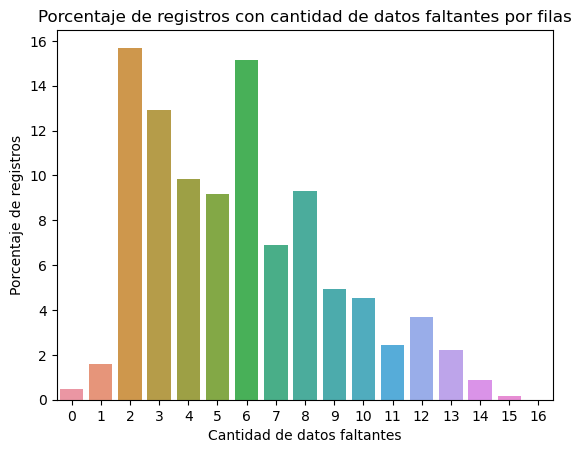

In [9]:
# Lo graficamos
sns.barplot(x=missing_by_row.index, y=missing_by_row.values) #grafico de barras
plt.title("Porcentaje de registros con cantidad de datos faltantes por filas")
plt.xlabel("Cantidad de datos faltantes")
plt.ylabel("Porcentaje de registros")
plt.show()

### Dispersión de datos

In [10]:
# Vemos el porcentaje de datos únicos con respecto al total. 
# Nos indica que tan diferentes son los datos en cada variable.  
data_dispersion = data.apply(lambda x: x.unique().size)
data_dispersion_df = pd.DataFrame(data_dispersion, columns=['count'])
data_dispersion_df["perc"] = (data_dispersion / data.shape[0]).round(3)*100
data_dispersion_df.sort_values(ascending=True, by='count')
#vemos que operation y country_name tienen porcentaje cero ya que tienen un único registro.
#el aumento del porcentaje nos indica que tan diferentes son los datos dentro de la variable.

,count,perc
operation,1,0.0
country_name,1,0.0
property_type,4,0.0
currency,5,0.0
state_name,28,0.0
rooms,32,0.0
floor,183,0.2
geonames_id,647,0.5
expenses,983,0.8
surface_covered_in_m2,996,0.8


In [11]:
#quisimos ver cuales son las variables con datos únicos menores a 100. 
print("Las variables con una cantidad de registros menores a 100 son:", )
for col in data.columns:
    if(data[col].nunique() < 100):
        print(col)
        print(data[col].unique())
        print()

Las variables con una cantidad de registros menores a 100 son:
operation
['sell']

property_type
['PH' 'apartment' 'house' 'store']

country_name
['Argentina']

state_name
['Capital Federal' 'Bs.As. G.B.A. Zona Sur' 'Buenos Aires Costa Atlántica'
 'Entre Ríos' 'Bs.As. G.B.A. Zona Norte' 'Santa Fe' 'Córdoba'
 'Bs.As. G.B.A. Zona Oeste' 'Misiones' 'Buenos Aires Interior' 'Salta'
 'Neuquén' 'Río Negro' 'San Luis' 'Mendoza' 'Corrientes' 'Chubut'
 'Tucumán' 'La Pampa' 'Chaco' 'San Juan' 'Santa Cruz' 'Tierra Del Fuego'
 'Catamarca' 'Santiago Del Estero' 'Jujuy' 'La Rioja' 'Formosa']

currency
['USD' nan 'ARS' 'PEN' 'UYU']

rooms
[nan  1.  4.  3.  2.  6.  5. 10.  7.  9.  8. 17. 22. 15. 12. 11. 14. 16.
 20. 13. 25. 19. 30. 18. 32. 24. 31. 21. 29. 27. 23. 28.]



### Analisis de correlacion entre columnas

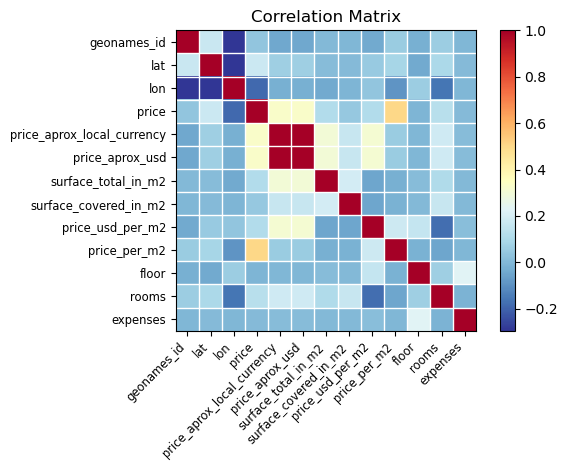

In [12]:
# Identificamos si existe una correlacion entre las diferentes variables numericas del dataset
corr = data.set_index("place_name").corr()
sm.graphics.plot_corr(corr, xnames=list(corr.columns))
plt.show()

# Hay una alta correlación entre price y price_per_m2, price_aprox_local_currency, price_aprox_usd 
## hay que ver el tipo de moneda de price seguramente comparta la misma que price_aprox_local_currency
# La relación entre price y price_per_m2 se puede deber a que se utiliza price para determinar el precio por m2 del inmueble
# la relación entre los variables precios y variables de superficies puede deberse que el precio sea una variable dependiente de la superficie 

## Exploración del dataset dividido en grupos de Properatti 

Para los siguientes pasos trabajaremos con el dataset dividido en tres grandes grupos:
-  Localización: que contiene las columnas relacionadas con la ubicación del inmueble y a su vez este dividido en dos subgrupos:
    - Ubicación: que contiene las columnas place_name, state_name, country_name y place_with_parent_names, es decir columnas con la localización política del inmueble.
    - Georeferenciada: que contiene las columnas geonames_id, lat y lon, es decir columnas con la localización geográfica del inmueble.
- Precio: que contiene las columnas relacionadas a los precios en distintas variantes. 
- Superficie: que contiene las columnas relacionadas con la superficie del inmueble

In [13]:
# Definimos 4 grupos de variables para poder trabajar con ellas de forma mas sencilla
places = ['place_name','place_with_parent_names', 'country_name','state_name']
geolocation = ['geonames_id', 'lat-lon','lat','lon']
price = ['price','currency','price_aprox_local_currency','price_aprox_usd','price_usd_per_m2','price_per_m2']
surface = ['surface_total_in_m2','surface_covered_in_m2']

### Localización por ubicación política

Exploración de las variables relacionadas con la ubicación: Por Provincia, Ciudad/Barrio, el conjunto de ubicación 
- country_name
- state_name 
- place_name                        
- place_with_parent_names              

vamos a:

- Explorar las variables 
- Visualizar los nan de estas columnas
- Relacionar las columnas country_name, state_name, place_name con la concatenación de ubicación en place_with_parent_names para ver si efectivamente corresponden o hay datos mal cargados

In [14]:
places_data = data[places].copy()   #asignamos el dataframe a la variable que utilizaremos en adelante
places_data.head()

,place_name,place_with_parent_names,country_name,state_name
0,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal
1,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur
2,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal
3,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal
4,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica


In [15]:
places_data.sample(10)

,place_name,place_with_parent_names,country_name,state_name
15565,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|La ...,Argentina,Bs.As. G.B.A. Zona Sur
86686,Adrogué,|Argentina|Bs.As. G.B.A. Zona Sur|Almirante Br...,Argentina,Bs.As. G.B.A. Zona Sur
46556,Barrio Norte,|Argentina|Capital Federal|Barrio Norte|,Argentina,Capital Federal
89825,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe
104231,Villa Elisa,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|Vil...,Argentina,Bs.As. G.B.A. Zona Sur
107062,Palermo,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal
107906,Rincón de Milberg,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Rinc...,Argentina,Bs.As. G.B.A. Zona Norte
106493,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe
18336,Tortuguitas,|Argentina|Bs.As. G.B.A. Zona Norte|Malvinas A...,Argentina,Bs.As. G.B.A. Zona Norte
59613,Congreso,|Argentina|Capital Federal|Congreso|,Argentina,Capital Federal


In [16]:
#Vemos más a detalle por variable los registros totales, los registros únicos, el dato más frecuente y su frecuencia
#Vemos que state_name contiene más de las 23 provincias que debería tener Argentina:posiblemente estén datos diferentes a provincias
places_data[places].describe()

,place_name,place_with_parent_names,country_name,state_name
count,121197,121220,121220,121220
unique,1060,1164,1,28
top,Córdoba,|Argentina|Santa Fe|Rosario|,Argentina,Capital Federal
freq,9254,8504,121220,32316


In [17]:
#ubicación "State_name" ¿por provincia?
#vamos a ver un poco más cuales son los valores únicos de state_name que deberían relacionarse al nombre de las provincias
places_data["state_name"].value_counts() #Excludes NA values by default.

#efectivamente state_name si contiene las 23 provincias argentinas, sin embargo, divide a Buenos Aires en la capital federal
# y el gran buenos aires más la costa atlántica 
# observamos que los datos están concentrados en Buenos Aires (Cap fed, zona norte, zona sur, oeste, atlántica, interior),
#  Cordoba, Santa fe 

Capital Federal                 32316
Bs.As. G.B.A. Zona Norte        25560
Bs.As. G.B.A. Zona Sur          13952
Córdoba                         12069
Santa Fe                        10172
Buenos Aires Costa Atlántica    10006
Bs.As. G.B.A. Zona Oeste         9322
Buenos Aires Interior            2291
Río Negro                         808
Neuquén                           733
Mendoza                           681
Tucumán                           674
Corrientes                        583
Misiones                          464
Entre Ríos                        369
Salta                             278
Chubut                            259
San Luis                          252
La Pampa                          157
Formosa                            65
Chaco                              57
San Juan                           40
Tierra Del Fuego                   31
Catamarca                          27
Jujuy                              26
Santa Cruz                         20
Santiago Del

In [18]:
# ubicación por place_name ¿ciudad-municipio o barrio?
places_data["place_name"].value_counts().head(20)
# NOtamos que existe una mexcla entre ciudades,municipios y barrios.
# Tigre es una ciudad al norte de la ciudad de Buenos Aires.
# Nordelta es una localidad urbana en el Partido de Tigre, Provincia de Buenos Aires 
## esta columna mezcla ciudades y barrios
# Capital Federal está como place_name 

Córdoba            9254
Rosario            8504
Mar del Plata      6534
Tigre              3324
Nordelta           3315
Belgrano           2992
Palermo            2885
La Plata           2534
Caballito          2273
Pilar              2228
Villa Urquiza      1632
Olivos             1590
Recoleta           1547
Lomas de Zamora    1529
Flores             1354
Ituzaingó          1340
Villa Crespo       1331
Capital Federal    1297
San Telmo          1216
Morón              1209
Name: place_name, dtype: int64

In [19]:
#nVemos algunos registros de place_with_parent_names
places_data["place_with_parent_names"].value_counts().head(10) 

# La variable representa el país/ "country_name", la provincia/ "state_name" (o division de la provincia), la ciudad principal/partido-municipio o barrio
# en el caso de capital federal"place_name"
# y un adicional que puede ser una localidad del partido (ejem: |Argentina|Bs.As. G.B.A. Zona Norte|Tigre|*Nordelta*|)
# los registros tienen entre 2  y 4 concatenaciones: 2 concatenaciones solo muestra hasta la ubicación por provincia, no brinda información relevante
### |Argentina|Capital Federal|  1297 no tiene nombre de barrio, desestimar o completar? 
### |Argentina|Córdoba|    2648no tiene nombre de barrio, desestimar o completar? 
# esta variable puede usarse para completar los datos faltantes de place_name 
# podemos chequear si el atributo "place_name" coincide con los datos aquí plasmados

|Argentina|Santa Fe|Rosario|                              8504
|Argentina|Córdoba|Córdoba|                               6606
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|    6534
|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nordelta|       3315
|Argentina|Capital Federal|Belgrano|                      2992
|Argentina|Capital Federal|Palermo|                       2885
|Argentina|Córdoba|                                       2648
|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|                2359
|Argentina|Capital Federal|Caballito|                     2273
|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|                1857
Name: place_with_parent_names, dtype: int64

In [20]:
# Para state_name vemos: cuales son los datos de place_name más frecuente, su frecuencia y cuantos registros diferentes existen 
places_data.groupby(["state_name"])["place_name"].describe()

# La variable place_name está representado principalmente por una ciudad-municipio de la provincia o division de esta

,count,unique,top,freq
state_name,,,,
Bs.As. G.B.A. Zona Norte,25537,264,Tigre,3324
Bs.As. G.B.A. Zona Oeste,9322,78,Morón,1209
Bs.As. G.B.A. Zona Sur,13952,123,La Plata,2534
Buenos Aires Costa Atlántica,10006,87,Mar del Plata,6534
Buenos Aires Interior,2291,99,Bahía Blanca,480
Capital Federal,32316,62,Belgrano,2992
Catamarca,27,6,Manantiales,17
Chaco,57,7,Resistencia,37
Chubut,259,16,Cushamen,100


## Verificar la calidad de los datos:


### Ubicación

Para verificar la calidad de los datos, principalmente, vamos a comparar las columnas que deberían tener la misma información y ver si coinciden o no. Por ejemplo, la columna "place_with_parent_names" debería contener dentro de su array la misma información que "place_name". Vamos a verificar si esto es cierto o no.

#### Corroborar si place_with_parent_names coincide con country_name, state_name, place_name 

In [21]:
# Convertimos la columna place_with_parent_names en una lista usando el separador "|"
# Eliminamos el separador inicial y final de la lista
places_data['place_with_parent_names'] = places_data['place_with_parent_names'].apply(lambda x: x.lstrip("|").rstrip("|").split("|"))
places_data['place_with_parent_names'].head()

0              [Argentina, Capital Federal, Mataderos]
1        [Argentina, Bs.As. G.B.A. Zona Sur, La Plata]
2              [Argentina, Capital Federal, Mataderos]
3                [Argentina, Capital Federal, Liniers]
4    [Argentina, Buenos Aires Costa Atlántica, Mar ...
Name: place_with_parent_names, dtype: object

In [22]:
# Función para chequear si los valores de la columna place_with_parent_names coinciden exactamente con 
# los valores de las columnas country_name, state_name, place_name
# Coincidir exactamente significa que la columna place_with_parent_names sólo tiene 3 elementos 
# y que los valores de los elementos coinciden en orden con los valores de las columnas country_name, state_name, place_name

def is_location_different(row):
    # la lista debería tener 3 elementos
    if len(row['place_with_parent_names']) != 3:
        return True
    if row['country_name'] == row['place_with_parent_names'][0] \
    and row['state_name'] == row['place_with_parent_names'][1] \
    and row['place_name'] == row['place_with_parent_names'][2]:
        return False
    else:
        return True

In [23]:
# Creamos la mascara utilizando la función is_location_different
mask = places_data.apply(lambda x: is_location_different(x), axis=1)
print("place_with_parent_names difference with country_name, state_name and place_name:", places_data[mask].shape[0])
places_data[mask][places].sample(10)

place_with_parent_names difference with country_name, state_name and place_name: 45220


,place_name,place_with_parent_names,country_name,state_name
66593,Banfield,"[Argentina, Bs.As. G.B.A. Zona Sur, Lomas de Z...",Argentina,Bs.As. G.B.A. Zona Sur
22963,Country Saint Thomas,"[Argentina, Bs.As. G.B.A. Zona Sur, Esteban Ec...",Argentina,Bs.As. G.B.A. Zona Sur
56354,Ciudadela,"[Argentina, Bs.As. G.B.A. Zona Oeste, Tres de ...",Argentina,Bs.As. G.B.A. Zona Oeste
99933,Morón,"[Argentina, Bs.As. G.B.A. Zona Oeste, Morón, M...",Argentina,Bs.As. G.B.A. Zona Oeste
80403,Lanús,"[Argentina, Bs.As. G.B.A. Zona Sur, Lanús, Lanús]",Argentina,Bs.As. G.B.A. Zona Sur
66916,Córdoba,"[Argentina, Córdoba]",Argentina,Córdoba
62509,Salta,"[Argentina, Salta]",Argentina,Salta
83476,Córdoba,"[Argentina, Córdoba]",Argentina,Córdoba
4170,Carmel Country Club,"[Argentina, Bs.As. G.B.A. Zona Norte, Pilar, C...",Argentina,Bs.As. G.B.A. Zona Norte
105725,La Plata,"[Argentina, Bs.As. G.B.A. Zona Sur, La Plata, ...",Argentina,Bs.As. G.B.A. Zona Sur


*Conclusión: Existen 45220 registros que no coinciden exactamente.* 

#### Análisis de los registros que no coinciden exactamente en las columnas places
___

Veamos cuáles son los registros que no coinciden exactamente en las columnas places

In [24]:
# Contamos la cantidad de valores de cada array de place_with_parent_names
destructured_places_with_parent_names_rows =  places_data['place_with_parent_names'].apply(lambda x: len(x)).value_counts()
destructured_places_with_parent_names_rows
# Este código nos devuelve la cantidad de filas que tenemos agrupadas en place_with_parent_names: va de dos a cinco especificaciones
# para la ubicación de un inmueble; hasta donde conocíamos, veníamos viendo hasta 3: País|Provincia|Ciudad o Barrio.
# veremos que descripción adicional nos brinda las concatenaciones >3.

3    76023
4    39869
2     4780
5      548
Name: place_with_parent_names, dtype: int64

In [25]:
# Vemos el porcentaje para graficarlo luego
destructured_places_with_parent_names_rows_percent =  places_data['place_with_parent_names'].apply(lambda x: len(x)).value_counts(normalize=True) * 100
destructured_places_with_parent_names_rows_percent

3    62.714899
4    32.889787
2     3.943244
5     0.452071
Name: place_with_parent_names, dtype: float64

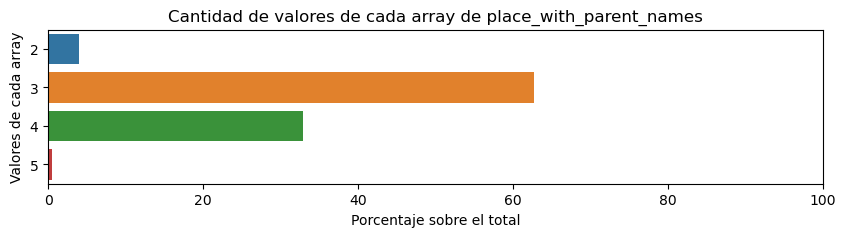

In [26]:
# Representamos la cantidad de grupo de datos contenidos en la variable place_with_parent_names
fig, ax = plt.subplots(figsize=(10,2))
sns.barplot(x=destructured_places_with_parent_names_rows_percent.values,y=destructured_places_with_parent_names_rows_percent.index, orient='h', ax=ax, ) 
ax.set_title('Cantidad de valores de cada array de place_with_parent_names') 
ax.set_xlabel('Porcentaje sobre el total') 
ax.set_ylabel('Valores de cada array')
plt.xlim(0,100)
plt.show()


De los pasos anteriores notamos: los registros que no coinciden exactamente son aquellas listas que no tienen 3 valores. De todas maneras tanto aquellos que tiene 2 como los que tienen 5 valores no tienen una cantidad significativa de registros. 

Revisamos que los valores que están en cada lista tengan su contraparte en las otras columnas aunque figuren en otro orden del array. Por ejemplo, si en place_with_parent_names figura "Argentina|Capital Federal|Palermo" y en place_name figura "Capital Federal", entonces el registro para este momento del análisis se considera válido.

In [27]:
# country_name
print("null values:", places_data['country_name'].isna().sum())
mask = ~places_data.apply(lambda x: x['country_name'] in x['place_with_parent_names'], axis=1)
print("place_with_parent_names difference with country_name:", places_data[mask].shape[0])

null values: 0
place_with_parent_names difference with country_name: 0


In [28]:
# state_name
print("null values:", places_data['state_name'].isna().sum())
mask = ~places_data.apply(lambda x: x['state_name'] in x['place_with_parent_names'], axis=1)
print("place_with_parent_names difference with state_name:", places_data[mask].shape[0])

null values: 0
place_with_parent_names difference with state_name: 0


In [29]:
# place_name
print("null values:", places_data['place_name'].isna().sum())
mask = ~places_data.apply(lambda x: x['place_name'] in x['place_with_parent_names'], axis=1)
print("place_with_parent_names difference with place_name:", places_data[mask].shape[0])


null values: 23
place_with_parent_names difference with place_name: 23


*Conclusión: La información que figura en las columnas place_name, country_name y state_name se encuentra en la columna place_with_parent_names aunque no exactamente igual (parece existir información extra) excepto en la columna 'place_name' con sus 23 NaNs que ya hemos identificado previamente.*

A continuación analizaremos esas columnas dividiendo el trabajo en partes dependiendo de la cantidad de elementos que contenga el array de la columna "place_with_parent_names".

#### Análisis de registros de place_with_parent_names con 3 valores
___

In [30]:
# Revisamos los place_with_parent_names con tres elementos
mask = places_data['place_with_parent_names'].apply(lambda x: len(x) == 3)
places_data_3_elements = places_data[mask].copy()
places_data_3_elements.shape

(76023, 4)

In [31]:
# Corroboramos que los valores de country_name, state_name y place_name coinciden con los valores de place_with_parent_names
print("country_name difference with place_with_parent_names[0]:", places_data_3_elements[places_data_3_elements['country_name'] != places_data_3_elements['place_with_parent_names'].apply(lambda x: x[0])].shape[0])
print("state_name difference with place_with_parent_names[1]:", places_data_3_elements[places_data_3_elements['state_name'] != places_data_3_elements['place_with_parent_names'].apply(lambda x: x[1])].shape[0])
print("place_name difference with place_with_parent_names[2]:", places_data_3_elements[places_data_3_elements['place_name'] != places_data_3_elements['place_with_parent_names'].apply(lambda x: x[2])].shape[0])

country_name difference with place_with_parent_names[0]: 0
state_name difference with place_with_parent_names[1]: 0
place_name difference with place_with_parent_names[2]: 23


In [32]:
# Vemos los datos correspondientes a los valores nulos de la columna place_name
mask = ~places_data.apply(lambda x: x['place_name'] in x['place_with_parent_names'], axis=1)
places_data_place_name_nan = places_data[mask].copy()
places_data_place_name_nan.head()

,place_name,place_with_parent_names,country_name,state_name
6489,NaN,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre]",Argentina,Bs.As. G.B.A. Zona Norte
10201,NaN,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre]",Argentina,Bs.As. G.B.A. Zona Norte
11451,NaN,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre]",Argentina,Bs.As. G.B.A. Zona Norte
14839,NaN,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre]",Argentina,Bs.As. G.B.A. Zona Norte
18622,NaN,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre]",Argentina,Bs.As. G.B.A. Zona Norte


In [33]:
#Extraemos el dato en la posicion que corresponde a Tigre y lo contabilizamos 
places_data_place_name_nan['place_with_parent_names'].apply(lambda x: x[2]).value_counts()

Tigre    23
Name: place_with_parent_names, dtype: int64

*Conclusión: Los registros que no tienen valor en place_name son los que no coinciden, todos del municipio de Tigre. El resto de los valores son exactamente iguales*  





#### Análisis de registros de place_with_parent_names con 4 valores
___

In [34]:
# Revisamos los place_with_parent_names con cuatro elementos
mask = places_data['place_with_parent_names'].apply(lambda x: len(x) == 4)
places_data_4_elements = places_data[mask].copy()
places_data_4_elements.shape


(39869, 4)

In [35]:
# Contamos los valores de la columna place_with_parent_names por el segundo elemento (descartamos el primero
# porque sabemos que siempre es Argentina)
places_data_4_elements['place_with_parent_names'].apply(lambda x: x[1]).value_counts()


Bs.As. G.B.A. Zona Norte        17198
Bs.As. G.B.A. Zona Sur          11638
Bs.As. G.B.A. Zona Oeste         7058
Capital Federal                  1198
Buenos Aires Costa Atlántica     1177
Buenos Aires Interior             962
Río Negro                         638
Name: place_with_parent_names, dtype: int64

In [36]:
# Confirmamos que los valores de la columna place_with_parent_names[1] coinciden con los valores de la columna state_name
mask = (places_data_4_elements['place_with_parent_names'].apply(lambda x: x[1]) != places_data_4_elements['state_name'])
print("place_with_parent_names[1] difference with state_name:", places_data_4_elements[mask].shape[0])


place_with_parent_names[1] difference with state_name: 0


In [37]:
# Confirmamos que los valores de la columna place_with_parent_names[2] coinciden con los valores de la columna place_name
mask = places_data_4_elements['place_with_parent_names'].apply(lambda x: x[2]) != places_data_4_elements['place_name']
print("place_with_parent_names[2] difference with place_name:", places_data_4_elements[mask].shape[0])
print("place_with_parent_names[2] proportional difference with place_name:", places_data_4_elements[mask].shape[0] / places_data_4_elements.shape[0])
places_data_4_elements_non_matching = places_data_4_elements[mask].copy()
places_data_4_elements_non_matching[places].sample(10)

place_with_parent_names[2] difference with place_name: 29842
place_with_parent_names[2] proportional difference with place_name: 0.7485013418947052


,place_name,place_with_parent_names,country_name,state_name
1245,Nordelta,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre, N...",Argentina,Bs.As. G.B.A. Zona Norte
68691,Temperley,"[Argentina, Bs.As. G.B.A. Zona Sur, Lomas de Z...",Argentina,Bs.As. G.B.A. Zona Sur
36672,Victoria,"[Argentina, Bs.As. G.B.A. Zona Norte, San Fern...",Argentina,Bs.As. G.B.A. Zona Norte
79528,Nordelta,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre, N...",Argentina,Bs.As. G.B.A. Zona Norte
15029,Los Polvorines,"[Argentina, Bs.As. G.B.A. Zona Norte, Malvinas...",Argentina,Bs.As. G.B.A. Zona Norte
1737,Los Pingüinos Country Club,"[Argentina, Bs.As. G.B.A. Zona Oeste, Ituzaing...",Argentina,Bs.As. G.B.A. Zona Oeste
21214,Matheu,"[Argentina, Bs.As. G.B.A. Zona Norte, Escobar,...",Argentina,Bs.As. G.B.A. Zona Norte
7109,Villa Luzuriaga,"[Argentina, Bs.As. G.B.A. Zona Oeste, La Matan...",Argentina,Bs.As. G.B.A. Zona Oeste
16510,Palermo Soho,"[Argentina, Capital Federal, Palermo, Palermo ...",Argentina,Capital Federal
95686,Florida,"[Argentina, Bs.As. G.B.A. Zona Norte, Vicente ...",Argentina,Bs.As. G.B.A. Zona Norte


In [38]:
# No coinciden en 29842 registros pero coinciden en el resto. 
# Confirmamos que los que coinciden son iguales al valor[3] en la cadena completa
mask = places_data_4_elements_non_matching['place_with_parent_names'].apply(lambda x: x[2]) == places_data_4_elements_non_matching['place_with_parent_names'].apply(lambda x: x[3])
places_data_4_elements_non_matching[mask].shape[0]/ places_data_4_elements_non_matching.shape[0]

0.0

In [39]:
# Confirmamos que los valores de la columna place_with_parent_names[3] coinciden con los valores de la columna place_name
mask = (places_data_4_elements['place_with_parent_names'].apply(lambda x: x[3]) != places_data_4_elements['place_name'])
print("place_with_parent_names[3] difference with place_name:", places_data_4_elements[mask].shape[0])
anti_mask = ~mask # Los que coinciden
places_data_4_elements[anti_mask][places].sample(10)

place_with_parent_names[3] difference with place_name: 0


,place_name,place_with_parent_names,country_name,state_name
21420,Benavidez,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre, B...",Argentina,Bs.As. G.B.A. Zona Norte
113768,Morón,"[Argentina, Bs.As. G.B.A. Zona Oeste, Morón, M...",Argentina,Bs.As. G.B.A. Zona Oeste
10108,Solares del Talar,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre, S...",Argentina,Bs.As. G.B.A. Zona Norte
64420,Olivos,"[Argentina, Bs.As. G.B.A. Zona Norte, Vicente ...",Argentina,Bs.As. G.B.A. Zona Norte
108517,La Plata,"[Argentina, Bs.As. G.B.A. Zona Sur, La Plata, ...",Argentina,Bs.As. G.B.A. Zona Sur
26336,Canning,"[Argentina, Bs.As. G.B.A. Zona Sur, Ezeiza, Ca...",Argentina,Bs.As. G.B.A. Zona Sur
98640,Olivos,"[Argentina, Bs.As. G.B.A. Zona Norte, Vicente ...",Argentina,Bs.As. G.B.A. Zona Norte
63082,Berazategui,"[Argentina, Bs.As. G.B.A. Zona Sur, Berazategu...",Argentina,Bs.As. G.B.A. Zona Sur
93460,Centro,"[Argentina, Buenos Aires Costa Atlántica, Mar ...",Argentina,Buenos Aires Costa Atlántica
81883,Ituzaingó,"[Argentina, Bs.As. G.B.A. Zona Oeste, Ituzaing...",Argentina,Bs.As. G.B.A. Zona Oeste


*Conclusión: De los 39869 registros con 4 valores, 29842 toman el valor de place_name del 4to valor de la lista. Los 10027 restantes toman el 3er valor.* que es siempre un barrio/localidad dentro del municipio: ejm: Glew localidad del municipio Almiramte Brown de zona sur del Gran Buenos Aires.

- place_name asignado a 3er valor de "place_with_parent_names": 10027
- place_name asignado a 4to valor de "place_with_parent_names": 29842

#### Análisis de registros de place_with_parent_names con 2 valores
___

In [40]:
# Reviso los place_with_parent_names con dos elementos
mask = places_data['place_with_parent_names'].apply(lambda x: len(x) == 2)
places_data_2_elements = places_data[mask].copy()
places_data_2_elements['place_with_parent_names'].value_counts()

[Argentina, Córdoba]                         2648
[Argentina, Capital Federal]                 1297
[Argentina, Bs.As. G.B.A. Zona Norte]         222
[Argentina, Mendoza]                          130
[Argentina, Buenos Aires Interior]            106
[Argentina, Tucumán]                           77
[Argentina, Bs.As. G.B.A. Zona Oeste]          65
[Argentina, Misiones]                          44
[Argentina, Santa Fe]                          33
[Argentina, Buenos Aires Costa Atlántica]      27
[Argentina, San Luis]                          24
[Argentina, Bs.As. G.B.A. Zona Sur]            24
[Argentina, Salta]                             21
[Argentina, Chubut]                            17
[Argentina, Neuquén]                           10
[Argentina, Río Negro]                          8
[Argentina, San Juan]                           7
[Argentina, Tierra Del Fuego]                   6
[Argentina, Catamarca]                          3
[Argentina, Santiago Del Estero]                3


In [41]:
# Reviso los place_with_parent_names de Córdoba y Capital Federal por contener el maypr numero de registros
mask = places_data_2_elements['place_with_parent_names'].apply(lambda x: x[1] == 'Córdoba' or x[1] == 'Capital Federal')
places_data_2_elements[mask].sample(10)

,place_name,place_with_parent_names,country_name,state_name
87614,Córdoba,"[Argentina, Córdoba]",Argentina,Córdoba
105791,Córdoba,"[Argentina, Córdoba]",Argentina,Córdoba
67737,Córdoba,"[Argentina, Córdoba]",Argentina,Córdoba
68983,Córdoba,"[Argentina, Córdoba]",Argentina,Córdoba
68237,Córdoba,"[Argentina, Córdoba]",Argentina,Córdoba
13611,Capital Federal,"[Argentina, Capital Federal]",Argentina,Capital Federal
110800,Córdoba,"[Argentina, Córdoba]",Argentina,Córdoba
97485,Córdoba,"[Argentina, Córdoba]",Argentina,Córdoba
69948,Capital Federal,"[Argentina, Capital Federal]",Argentina,Capital Federal
74174,Capital Federal,"[Argentina, Capital Federal]",Argentina,Capital Federal


In [42]:
# Pareciera ser que todos los lugares que tienen dos elementos en place_with_parent_names repiten el nombre del estado en place_name
# Corroboramos esto
mask = places_data_2_elements['place_name'] != places_data_2_elements['state_name']
places_data_2_elements[mask].shape


(0, 4)

*Conclusión: En los 4780 registros de place_with_parent_names que tienen 2 valores se utilizó state_name como place_name.* 
*Es decir, la ciudad principal de la provincia.*

#### Análisis de registros de place_with_parent_names con 5 valores
___

In [43]:
# Revisamos los place_with_parent_names con 5 elementos
mask = places_data['place_with_parent_names'].apply(lambda x: len(x) == 5)
places_data_5_elements = places_data[mask].copy()
print(places_data_5_elements['place_with_parent_names'].shape)
places_data_5_elements.sample(5)

(548,)


,place_name,place_with_parent_names,country_name,state_name
19697,Barrio Los Alisos,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre, N...",Argentina,Bs.As. G.B.A. Zona Norte
1307,BarrioPortezuelo,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre, N...",Argentina,Bs.As. G.B.A. Zona Norte
34483,Barrio Los Alisos,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre, N...",Argentina,Bs.As. G.B.A. Zona Norte
1127,Barrio Los Alisos,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre, N...",Argentina,Bs.As. G.B.A. Zona Norte
52510,Barrio Los Alisos,"[Argentina, Bs.As. G.B.A. Zona Norte, Tigre, N...",Argentina,Bs.As. G.B.A. Zona Norte


In [44]:
# Revisamos si alguno de los valores no corresponde a Nordelta
places_data_5_elements['place_with_parent_names'].apply(lambda x: x[3] != 'Nordelta').sum()

0

In [45]:
# Corroboramos que los valores de la columna place_with_parent_names[2] coinciden con los valores de la columna place_name
mask = (places_data_5_elements['place_with_parent_names'].apply(lambda x: x[2]) != places_data_5_elements['place_name'])
print("place_with_parent_names[2] difference with place_name:", places_data_5_elements[mask].shape[0])
print("place_with_parent_names[2] proportional difference with place_name:", places_data_5_elements[mask].shape[0] / places_data_5_elements.shape[0])


place_with_parent_names[2] difference with place_name: 548
place_with_parent_names[2] proportional difference with place_name: 1.0


In [46]:
# Corroboramos que los valores de la columna place_with_parent_names[3] coinciden con los valores de la columna place_name
mask = (places_data_5_elements['place_with_parent_names'].apply(lambda x: x[3]) != places_data_5_elements['place_name'])
print("place_with_parent_names[3] difference with place_name:", places_data_5_elements[mask].shape[0])
print("place_with_parent_names[3] proportional difference with place_name:", places_data_5_elements[mask].shape[0] / places_data_5_elements.shape[0])


place_with_parent_names[3] difference with place_name: 548
place_with_parent_names[3] proportional difference with place_name: 1.0


In [47]:
# Corroboramos que los valores de la columna place_with_parent_names[4] coinciden con los valores de la columna place_name
mask = (places_data_5_elements['place_with_parent_names'].apply(lambda x: x[4]) != places_data_5_elements['place_name'])
print("place_with_parent_names[4] difference with place_name:", places_data_5_elements[mask].shape[0])
print("place_with_parent_names[4] proportional difference with place_name:", places_data_5_elements[mask].shape[0] / places_data_5_elements.shape[0])

place_with_parent_names[4] difference with place_name: 0
place_with_parent_names[4] proportional difference with place_name: 0.0


*Conclusión: Los 548 registros de place_with_parent_names que tienen 5 valores son de Nordelta y el último valor se refiere al Barrio. place_name toma los valores del barrio*


> ##### Conclusiones finales sobre columnas de ubicación: 
> - Existen como máximo 5 tipos de registros en place_with_parent_names: País, Provincia, Municipio, Ciudad, Barrio
> - País y Provincia son iguales a country_name y state_name
> - Place_name se le asigna el valor de municipio: 76000 + 10027 = 86027
> - Place_name se le asigna el valor de ciudad: 29842 (en  estos casos existe el valor municipio también )
> - Place_name se le asigna el valor de barrio: 548 (en estos casos existe el valor municipio y ciudad también)
> - Place_name se le asigna el valor de state_name: 4780 (en estos casos no existe el valor municipio y ciudad)
> - Place_name se le asigna el valor de NaN: 23 (en estos casos existe el valor municipio y ciudad)
> ___
> Por lo tanto se puede concluir que para dar mayor consistencia es posible imputar place_name con el valor del municipio en las mayoría de los casos. Confrontar con geoNamesId.
> ___








### Geolocalización

Analizamos  lat-lon para ver si habían registros duplicados considerando que si existe una misma coordenadas son las misma propiedad.

In [48]:
## Creamos una copia de data en la que podamos borrar los nan y agrupamos por lat y lon, contamos sus valores y
# le decimos que nos devuelva cuantos registros hay mayores a 1 en forma descendente para todo el dataset.
data_copy = data.copy()
data_copy.dropna(subset=['lat-lon'], inplace=True)
data_copy_group = data_copy.groupby('lat-lon').count()
data_copy_group[data_copy_group['place_name'] > 1].sort_values(by='operation', ascending=False)

#llama la atención que existan coordenadas repetidas, podríamos inferir que las coordenadas no son especificas de la ubicación del
# inmueble, sino de un punto de referencia  

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat,lon,price,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
lat-lon,,,,,,,,,,,,,,,,,,,,,
"-34.4026444,-58.6684776",312,312,312,312,312,312,0,312,312,309,...,312,306,309,0,231,0,312,312,312,312
"-34.40014,-58.64985",271,271,271,271,271,271,0,271,271,270,...,270,264,269,2,205,1,271,271,271,271
"-34.6428675967,-58.4376599743",259,259,259,259,259,259,259,259,259,6,...,4,6,3,0,0,0,259,259,259,259
"-34.425087,-58.5796585",224,224,223,224,224,224,107,224,224,213,...,220,199,209,0,81,0,224,224,224,224
"-34.5895459,-58.3973636",156,156,156,156,156,156,156,156,156,148,...,156,148,148,2,144,2,156,156,156,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"-34.5844431705,-58.4171643673",2,2,2,2,2,2,2,2,2,2,...,1,1,1,0,0,2,2,2,2,2
"-34.5841733,-58.4008772",2,2,2,2,2,2,2,2,2,2,...,2,2,2,0,0,2,2,2,2,2
"-34.58412,-58.453668",2,2,2,2,2,2,2,2,2,2,...,2,0,2,2,2,0,2,2,2,2


In [49]:
## seguimos chequeando si si existe algún dato duplicado en lat-lon
print(data.duplicated().any())
print(data['lat-lon'].duplicated().any())
print(data_copy.shape)

# no existen columnas duplicadas, pero si existen datos de lat-lon iguales en un total de 69670 filas 

False
True
(69670, 25)


In [50]:
#Quisimos ver los datos completos que tienen como coordenadas los 312 casos que vimos anteriormente
data_copy[data_copy['lat-lon'] == '-34.4026444,-58.6684776']

#vemos que los datos repetidos de lat y lon no se deben al mismo inmueble

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
1284,sell,apartment,Barrio Los Alisos,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4026444,-58.6684776",-34.402644,-58.668478,...,52.0,3203.389831,3634.615385,NaN,2.0,NaN,http://www.properati.com.ar/15hsc_venta_depart...,Departamento de 2 ambientes con vista al lago ...,PORTEZUELO | Marinas del Portezuelo - 2 ambien...,https://thumbs4.properati.com/9/a49C3o5BkTdafI...
1287,sell,apartment,Barrio Los Alisos,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4026444,-58.6684776",-34.402644,-58.668478,...,49.0,2894.736842,3367.346939,NaN,2.0,NaN,http://www.properati.com.ar/15hsi_venta_depart...,"Departamento de 2 ambientes muy luminoso, bar...",PORTEZUELO | Marinas del Portezuelo - Departam...,https://thumbs4.properati.com/9/7f4Vk-cijSd_Vd...
1306,sell,apartment,Barrio Los Alisos,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4026444,-58.6684776",-34.402644,-58.668478,...,54.0,2463.768116,3148.148148,NaN,2.0,NaN,http://www.properati.com.ar/15htl_venta_depart...,Unidad de 2 ambientes muy luminosa. Dormitorio...,PORTEZUELO | Marinas del Portezuelo - Albatros...,https://thumbs4.properati.com/3/0ivvcFWZzuAU3t...
4648,sell,apartment,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4026444,-58.6684776",-34.402644,-58.668478,...,76.0,2171.052632,2171.052632,NaN,2.0,NaN,http://www.properati.com.ar/15nbg_venta_depart...,"Departamento a estrenar en edificio Delta 8 , ...","Departamento en venta en Edificio Delta 8, Nor...",https://thumbs4.properati.com/5/tWSqJjKwu1i53r...
9502,sell,house,Barrio Los Alisos,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4026444,-58.6684776",-34.402644,-58.668478,...,295.0,2660.818713,3084.745763,NaN,NaN,NaN,http://www.properati.com.ar/164jj_venta_casa_n...,"Excelente casa a estrenar, entrega Julio 2017....",Hermosa Casa a estrenar en Lagos del Golf - No...,https://thumbs4.properati.com/8/JqL-_BgzwTcb9h...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113559,sell,apartment,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4026444,-58.6684776",-34.402644,-58.668478,...,58.0,1623.931624,3275.862069,NaN,2.0,NaN,http://www.properati.com.ar/1c8ie_venta_depart...,"""Departamento MUY luminoso de 2 ambientes y 1/...",Departamento 2 1/2 ambientes con vista al rio ...,https://thumbs4.properati.com/6/i7DP23BhojHDVu...
114089,sell,apartment,BarrioPortezuelo,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4026444,-58.6684776",-34.402644,-58.668478,...,83.0,2231.404959,3253.012048,NaN,3.0,NaN,http://www.properati.com.ar/1c9dc_venta_depart...,Living comedor y escritorio en L con salida al...,3 ambientes en esquina en venta a estrenar con...,https://thumbs4.properati.com/1/L4o5Ic0mJU-WgZ...
114409,sell,apartment,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4026444,-58.6684776",-34.402644,-58.668478,...,68.0,1886.363636,3661.764706,NaN,3.0,NaN,http://www.properati.com.ar/1c9ue_venta_depart...,Muy linda planta baja con jardín y amplia gale...,Venta amplio departamento en PB,https://thumbs4.properati.com/3/xM5r5TAlaez-FQ...
114425,sell,house,Barrio La Alameda,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4026444,-58.6684776",-34.402644,-58.668478,...,177.0,937.500000,2542.372881,NaN,NaN,NaN,http://www.properati.com.ar/1c9vc_venta_casa_b...,Espectacular casa construida en dos plantas a ...,Espectacular casa en el barrio


No es posible determinar si es la misma propiedad porque lat-lon se refiere muchas veces a la ubicación aproximada. 

In [51]:
# Creamos un nuevo dataframe con las columnas que nos interesan
geo_location_data = data[ geolocation].copy()
geo_location_data.head()

,geonames_id,lat-lon,lat,lon
0,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839
1,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330
2,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982
3,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424
4,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447


In [52]:
# Vemos el porcentaje de valores nulos por columna
geo_location_data.isnull().sum()/geo_location_data.shape[0] * 100


geonames_id    15.440521
lat-lon        42.525986
lat            42.525986
lon            42.525986
dtype: float64

<AxesSubplot:>

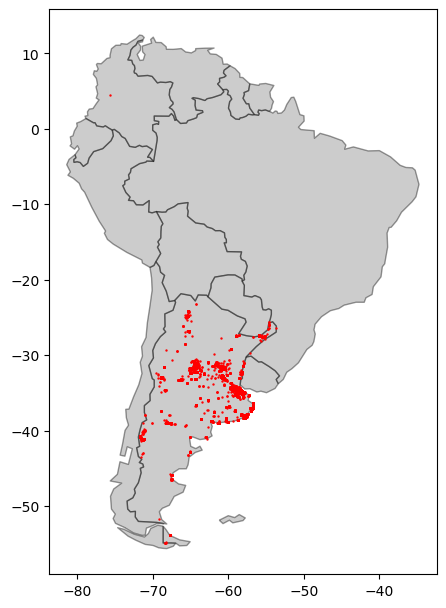

In [53]:
# Visualizamos en el mapa de SurAmerica si los datos de lat y lon pertenecen efectivamente a Argentina
# convertimos el dataframe a geodataframe
geo_location_data_gdf = gpd.GeoDataFrame(geo_location_data, geometry=gpd.points_from_xy(geo_location_data.lon, geo_location_data.lat))

# Ubicamos los puntos en el mapa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
latin_america = world[world['continent'] == 'South America']
fig, ax = plt.subplots(figsize=(5,10))
latin_america.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
geo_location_data_gdf.plot(ax=ax, markersize=0.5, color='red')

In [54]:
# Existe una propiedad que se encuentra fuera de la Argentina (en Colombia). 
# La buscamos en el dataframe original
# buscamos el polígono de Colombia
geo_colombia = world[world['name'] == 'Colombia']

# Buscamos la propiedad que se encuentra en Colombia
geo_outlier_index = geo_location_data_gdf[geo_location_data_gdf.within(geo_colombia['geometry'].iloc[0])].index

# La buscamos en el dataframe original
data.iloc[geo_outlier_index]


,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
9761,sell,house,Córdoba,|Argentina|Córdoba|,Argentina,Córdoba,3860255.0,"4.5458426,-75.67893099",4.545843,-75.678931,...,NaN,NaN,NaN,2.0,3.0,NaN,http://www.properati.com.ar/165i3_venta_casa_c...,Casa en Venta de 2 dorm. en Armenia,SE VENDE CASA EN EL BARRIO EL LIMONAR,https://thumbs4.properati.com/2/2huBKPZv0RyWda...


Es una propiedad súper interesante, por latitud y longitud está en Colombia, pero por el nombre de la provincia está en Argentina, la descripción habla de Armenia y el título del el Barrio el Limonar.

En una rápida búsqueda por internet encontramos que la propiedad se encuentra en el barrio El Limonar de Armenia, Colombia.

La descartaremos sin dudas.

______

#### Corroborar si lat-lon coincide con las columnas lat y lon

In [55]:
# Corroboremos que los valores nulos en lat-lon son los mismos que en lat y lon
geo_location_data[geo_location_data['lat-lon'].isnull()]['lat'].isnull().sum() == geo_location_data[geo_location_data['lat-lon'].isnull()]['lon'].isnull().sum()

True

In [56]:
# Dropeamos los valores nulos de lat-lon
geo_location_data.dropna(subset=['lat-lon'], inplace=True)
geo_location_data.isnull().sum()

geonames_id    10532
lat-lon            0
lat                0
lon                0
geometry           0
dtype: int64

In [57]:
# Convertimos la columna lat-lon en dos columnas nuevas
geo_location_data['lat_alt'] = geo_location_data['lat-lon'].apply(lambda x: x.split(',')[0])
geo_location_data['lon_alt'] = geo_location_data['lat-lon'].apply(lambda x: x.split(',')[1])
geo_location_data.head()


,geonames_id,lat-lon,lat,lon,geometry,lat_alt,lon_alt
0,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,POINT (-58.50884 -34.66182),-34.6618237,-58.5088387
1,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,POINT (-57.96433 -34.90388),-34.9038831,-57.9643295
2,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,POINT (-58.52298 -34.65226),-34.6522615,-58.5229825
3,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,POINT (-58.51642 -34.64780),-34.6477969,-58.5164244
4,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,POINT (-57.54945 -38.00263),-38.0026256,-57.5494468


In [58]:
# Vemos los tipos de datos
geo_location_data.dtypes

geonames_id     float64
lat-lon          object
lat             float64
lon             float64
geometry       geometry
lat_alt          object
lon_alt          object
dtype: object

In [59]:
# convertimos las nuevas columnas a float
geo_location_data['lat_alt'] = geo_location_data['lat_alt'].astype(float)
geo_location_data['lon_alt'] = geo_location_data['lon_alt'].astype(float)
geo_location_data.dtypes

geonames_id     float64
lat-lon          object
lat             float64
lon             float64
geometry       geometry
lat_alt         float64
lon_alt         float64
dtype: object

In [60]:
# Comprobamos que los valores de las nuevas columnas son iguales a los de las columnas originales
print("Diferencia entre lat:",(geo_location_data['lat_alt'] != geo_location_data['lat']).sum())
print("Diferencia entre lon:",(geo_location_data['lon_alt'] != geo_location_data['lon']).sum())
# En proporción
print("Diferencia en proporción de lat",(geo_location_data['lat_alt'] != geo_location_data['lat']).sum()/ geo_location_data.shape[0])
print("Diferencia en proporción de lon",(geo_location_data['lon_alt'] != geo_location_data['lon']).sum()/ geo_location_data.shape[0])


Diferencia entre lat: 11507
Diferencia entre lon: 14658
Diferencia en proporción de lat 0.16516434620353093
Diferencia en proporción de lon 0.21039184728003446


Hay diferencias en 21% los casos. Veamos si es una diferencia significativa

Revisamos el margen de diferencia redondeando progresivamente.

In [61]:
Decimal(geo_location_data['lon'][0]).as_tuple().exponent

-46

In [62]:
# Reviso la cantidad de decimales que tienen los valores de lat y lon
geo_location_data['lat'].apply(lambda x: Decimal(x).as_tuple().exponent).value_counts()

-47    33560
-46    16130
-45     7979
-44     4494
-48     3399
-43     2077
-42     1028
-41      564
-40      164
-39      155
-38       55
-37       32
-36       18
-35        5
-7         4
-8         2
 0         2
-34        1
-4         1
Name: lat, dtype: int64

In [63]:
geo_location_data['lon'].apply(lambda x: Decimal(x).as_tuple().exponent).value_counts()

-47    31972
-46    18963
-45     9048
-44     5085
-43     2337
-42     1188
-41      561
-40      213
-39      190
-38       52
-37       28
-36       20
-34        4
-35        3
 0         2
-8         1
-2         1
-32        1
-4         1
Name: lon, dtype: int64

In [64]:
# Vamos redondeando progresivamente los valores de lat y lon
lat_decimal_diff = []
for i in range(47,0,-1):
    margin = (geo_location_data['lat_alt'].round(i) != geo_location_data['lat'].round(i)).sum()/ geo_location_data.shape[0]
    lat_decimal_diff.insert(0,margin)
    # print('Margen de diferencia de',i,'decimales en latitud:', margin)
# Buscamos dónde el margen de diferencia es menor al 1%
    if margin <= 0.01:
        print('Margen de diferencia de',i,'decimales en latitud:', margin)
   
print("////////////////////////////////////")   

lon_decimal_diff = []
for i in range(47,0,-1):
    margin = (geo_location_data['lon_alt'].round(i) != geo_location_data['lon'].round(i)).sum()/ geo_location_data.shape[0]
    lon_decimal_diff.insert(0,margin)
    # print('Margen de diferencia de',i,'decimales en longitud:', margin)
# Buscamos dónde el margen de diferencia es menor al 1%
    if margin <= 0.01:
        print('Margen de diferencia de',i,'decimales en latitud:', margin)

Margen de diferencia de 14 decimales en latitud: 0.009157456581024832
Margen de diferencia de 13 decimales en latitud: 0.0
Margen de diferencia de 12 decimales en latitud: 0.0
Margen de diferencia de 11 decimales en latitud: 0.0
Margen de diferencia de 10 decimales en latitud: 0.0
Margen de diferencia de 9 decimales en latitud: 0.0006171953495048084
Margen de diferencia de 8 decimales en latitud: 0.0
Margen de diferencia de 7 decimales en latitud: 0.0
Margen de diferencia de 6 decimales en latitud: 0.0027271422419979903
Margen de diferencia de 5 decimales en latitud: 0.0025405482991244436
Margen de diferencia de 4 decimales en latitud: 0.0
Margen de diferencia de 3 decimales en latitud: 0.0
Margen de diferencia de 2 decimales en latitud: 0.0
Margen de diferencia de 1 decimales en latitud: 0.0
////////////////////////////////////
Margen de diferencia de 13 decimales en latitud: 0.0
Margen de diferencia de 12 decimales en latitud: 0.0
Margen de diferencia de 11 decimales en latitud: 0.0


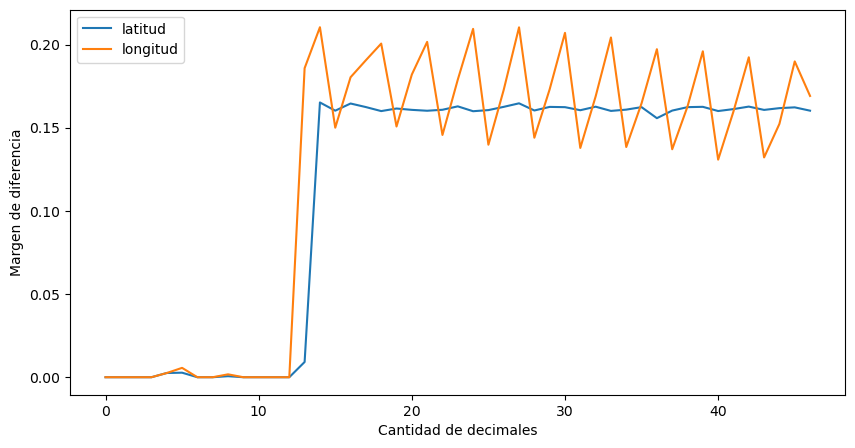

In [65]:
# Lo graficamos
plt.figure(figsize=(10,5))
plt.plot(lat_decimal_diff, label='latitud')
plt.plot(lon_decimal_diff, label='longitud')
plt.ylabel('Margen de diferencia')
plt.xlabel('Cantidad de decimales')
plt.legend()

In [66]:
geo_location_data_gdf = gpd.GeoDataFrame(geo_location_data, geometry=gpd.points_from_xy(geo_location_data.lon, geo_location_data.lat))
geo_location_data_gdf.head()

,geonames_id,lat-lon,lat,lon,geometry,lat_alt,lon_alt
0,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,POINT (-58.50884 -34.66182),-34.661824,-58.508839
1,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,POINT (-57.96433 -34.90388),-34.903883,-57.964329
2,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,POINT (-58.52298 -34.65226),-34.652262,-58.522982
3,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,POINT (-58.51642 -34.64780),-34.647797,-58.516424
4,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,POINT (-57.54945 -38.00263),-38.002626,-57.549447



> Como se puede ver, las diferencias entre lat-lon y lat y lon comienzan a partir de los 13 decimales por lo que podemos descartarla como una diferencia significativa.
> 
> Por otro lado, también hemos comprobado que los valores de lat lon provienen de convertir la variable a geometry y obtener de ahí lat y lon
>
> Entonces podemos concluir que la variable lat-lon es redundante y podemos eliminarla.
> ____ 

#### Análisis de propiedades con igual latitud y longitud con otras propiedades

Vamos a buscar si hay muchos puntos iguales para refutar la hipótesis de que se utilizó la misma ubicación para varias propiedades

In [67]:
# Primero veamos una visualización de los datos de Capital Federal para ver si parece haber una gran concentración 
# de propiedades en algún lugar específico o están dispersas por toda la ciudad.
geo_location_data_gdf_capital = geo_location_data_gdf[data['state_name']=='Capital Federal' ]
geo_location_data_gdf_capital['geometry']

c:\Users\LuisD\anaconda3\envs\dh\lib\site-packages\geopandas\geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


0         POINT (-58.50884 -34.66182)
2         POINT (-58.52298 -34.65226)
3         POINT (-58.51642 -34.64780)
7         POINT (-58.44336 -34.55987)
8         POINT (-58.44336 -34.55987)
                     ...             
121153    POINT (-58.40252 -34.59921)
121158    POINT (-58.39737 -34.58743)
121160    POINT (-58.44268 -34.56369)
121209    POINT (-58.44268 -34.56369)
121217    POINT (-58.47560 -34.57064)
Name: geometry, Length: 23770, dtype: geometry

In [68]:
# Ubicamos los puntos en el mapa
df_barrios_capital = pd.read_csv('./data/barrios.csv', sep=',', encoding='latin-1')
import shapely.wkt

df_barrios_capital["WKT"] = df_barrios_capital["WKT"].apply(shapely.wkt.loads) 
df_barrios_capital = gpd.GeoDataFrame(df_barrios_capital, geometry='WKT')


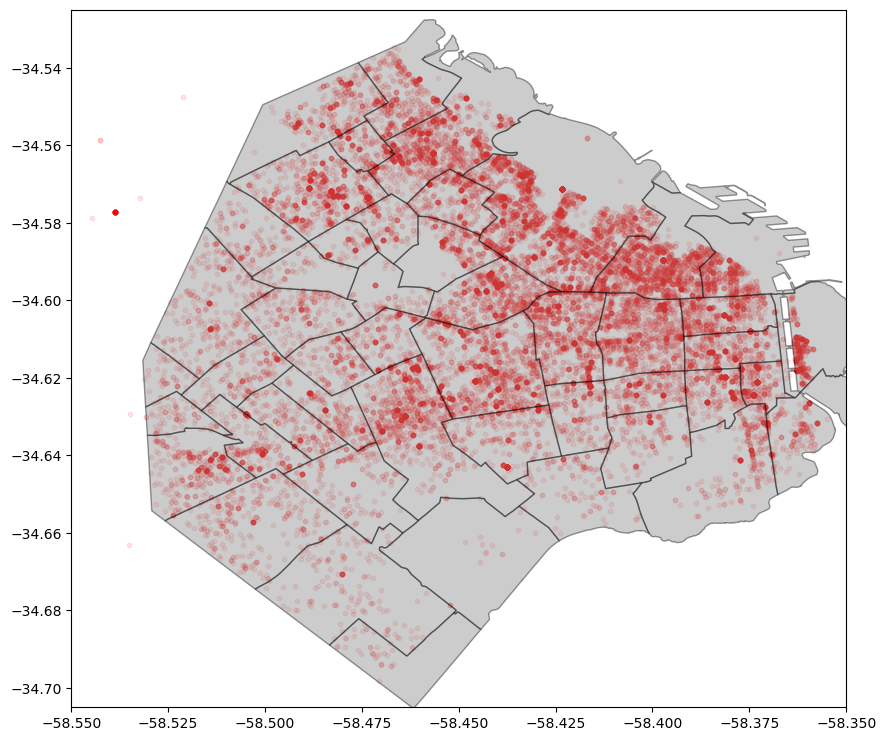

In [69]:
fig, ax = plt.subplots(figsize=(10,20))

geo_location_data_gdf_capital.plot(ax=ax, markersize=10, color='red', alpha=0.1) 
df_barrios_capital.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
plt.xlim(-58.55,-58.350)
plt.ylim(-34.705,-34.525) 
plt.show()

In [70]:
# Ahora veamos en todo el dataset cuántas propiedades comparten la misma ubicación.
different_locations = geo_location_data_gdf['geometry'].value_counts()
print('Cantidad de propiedades por punto:', different_locations) 

Cantidad de propiedades por punto: POINT (-58.66848 -34.40264)    312
POINT (-58.64985 -34.40014)    271
POINT (-58.43766 -34.64287)    259
POINT (-58.57966 -34.42509)    224
POINT (-58.39736 -34.58955)    156
                              ... 
POINT (-64.16211 -31.40195)      1
POINT (-64.18766 -31.42778)      1
POINT (-64.18595 -31.41274)      1
POINT (-64.17189 -31.41249)      1
POINT (-58.46064 -34.62950)      1
Name: geometry, Length: 47203, dtype: int64


In [71]:
prop_qty_per_point = []
for i in range(1,different_locations[0]+1):
    (different_locations == i).sum() / different_locations.shape[0] * 100
    prop_qty_per_point.append((different_locations == i).sum() / different_locations.shape[0] * 100)
prop_qty_per_point = pd.DataFrame(prop_qty_per_point, columns=['Porcentaje'], index=range(1,different_locations[0]+1))
prop_qty_per_point.reset_index(inplace=True)
prop_qty_per_point.rename(columns={'index':'Cantidad de propiedades por punto'}, inplace=True)
prop_qty_per_point.head(10)

,Cantidad de propiedades por punto,Porcentaje
0,1,85.651336
1,2,8.353283
2,3,2.313412
3,4,1.091032
4,5,0.548694
5,6,0.449124
6,7,0.245747
7,8,0.213969
8,9,0.144059
9,10,0.161007


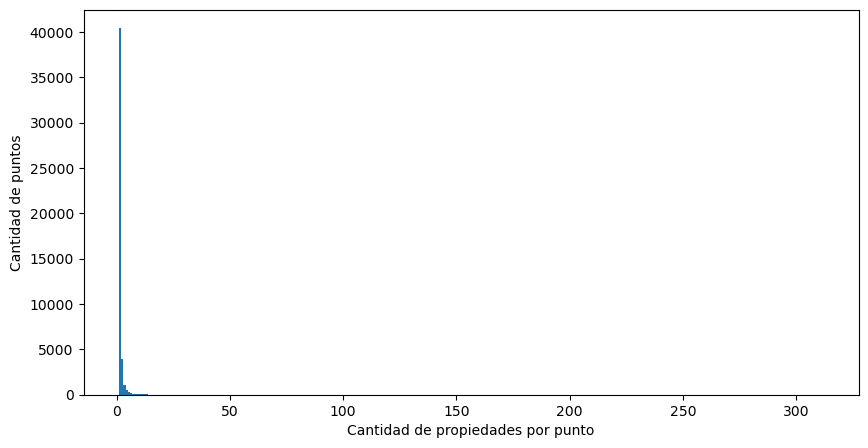

In [72]:
# Lo graficamos
plt.figure(figsize=(10,5))
plt.hist(different_locations, bins=different_locations[0]+1)
plt.ylabel('Cantidad de puntos')
plt.xlabel('Cantidad de propiedades por punto')
plt.show()



Veamos dónde se encuentran las propiedades que más tienen lat y lon iguales

In [73]:
most_shared_point_props = geo_location_data_gdf[geo_location_data_gdf['geometry'].isin(different_locations.index[0:11])]
 

<AxesSubplot:>

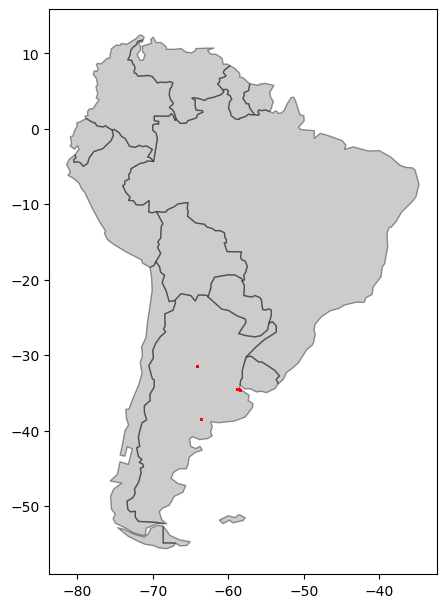

In [74]:
fig, ax = plt.subplots(figsize=(5,10))
latin_america.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
most_shared_point_props.plot(ax=ax, markersize=0.5, color='red')

In [75]:
# Parece que están todas en la Argentina
# Descargamos un mapa de la Argentina por municipios para averiguar qué municipios son los que tienen más propiedades en el mismo punto.
# https://www.ign.gob.ar/NuestrasActividades/InformacionGeoespacial/CapasSIG
municipios_geo = gpd.read_file('./data/municipio/municipio.shp')
municipios_geo.head()

,gid,objeto,fna,gna,nam,in1,fdc,sag,geometry
0,470,Municipio,Municipio Loreto,Municipio,Loreto,540077,Ministerio de Ecología,IGN,"POLYGON ((-55.44698 -27.39184, -55.44724 -27.3..."
1,730,Municipio,Comuna Angeloni,Comuna,Angeloni,823862,Servicio de Catastro e Información Territorial,IGN,"POLYGON ((-60.67225 -30.74442, -60.67913 -30.7..."
2,99,Municipio,Municipio Campana,Municipio,Campana,060126,ARBA - Gerencia de Servicios Catastrales,IGN,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."
3,33,Municipio,Municipio El Huecú,Municipio,El Huecú,580182,Direc. Pcial. de Catastro e Inf. Territorial,IGN,"POLYGON ((-70.54255 -37.65973, -70.54988 -37.6..."
4,939,Municipio,Municipio Calilegua,Municipio,Calilegua,380126,Direc. Grl. de Catastro,IGN,"POLYGON ((-64.85258 -23.62648, -64.84967 -23.6..."


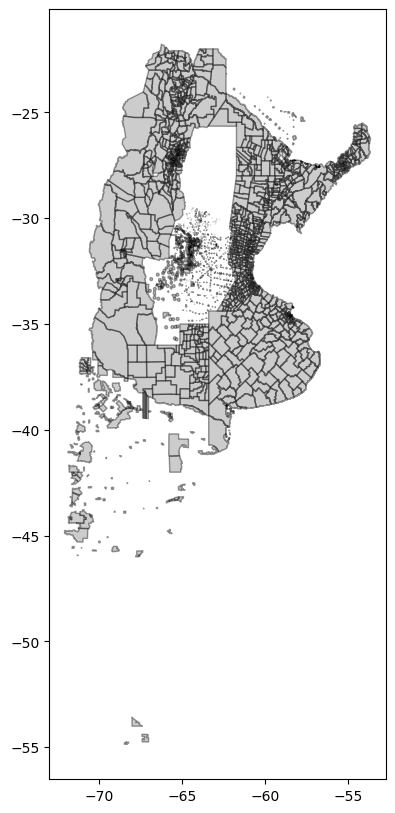

In [76]:
fig, ax = plt.subplots(figsize=(5,10))
municipios_geo.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
plt.show()

In [77]:
# Veamos en qué municipios están las propiedades que comparten el mismo punto.
# convertimos a coordenadas geográficas para poder hacer el join con el geodataframe de las propiedades.
most_shared_point_props.crs = "EPSG:4326"
most_shared_point_props = most_shared_point_props.to_crs(epsg=4326) 

In [78]:
# Hacemos el join con el geodataframe de los municipios.
most_shared_point_props_municipios = gpd.sjoin(most_shared_point_props, municipios_geo, how="inner")
most_shared_point_props_municipios.head()

,geonames_id,lat-lon,lat,lon,geometry,lat_alt,lon_alt,index_right,gid,objeto,fna,gna,nam,in1,fdc,sag
18,3427753.0,"-34.425087,-58.5796585",-34.425087,-58.579659,POINT (-58.57966 -34.42509),-34.425087,-58.579659,118,90,Municipio,Municipio Tigre,Municipio,Tigre,060805,ARBA - Gerencia de Servicios Catastrales,IGN
574,NaN,"-34.40014,-58.64985",-34.400140,-58.649850,POINT (-58.64985 -34.40014),-34.400140,-58.649850,118,90,Municipio,Municipio Tigre,Municipio,Tigre,060805,ARBA - Gerencia de Servicios Catastrales,IGN
577,NaN,"-34.40014,-58.64985",-34.400140,-58.649850,POINT (-58.64985 -34.40014),-34.400140,-58.649850,118,90,Municipio,Municipio Tigre,Municipio,Tigre,060805,ARBA - Gerencia de Servicios Catastrales,IGN
585,NaN,"-34.40014,-58.64985",-34.400140,-58.649850,POINT (-58.64985 -34.40014),-34.400140,-58.649850,118,90,Municipio,Municipio Tigre,Municipio,Tigre,060805,ARBA - Gerencia de Servicios Catastrales,IGN
591,3427753.0,"-34.425087,-58.5796585",-34.425087,-58.579659,POINT (-58.57966 -34.42509),-34.425087,-58.579659,118,90,Municipio,Municipio Tigre,Municipio,Tigre,060805,ARBA - Gerencia de Servicios Catastrales,IGN


In [79]:
most_shared_point_props_municipios['fna'].value_counts()

Municipio Tigre                 922
Comuna 7                        259
Comuna 2                        156
Comuna 14                       142
Municipio Córdoba               132
Comuna 13                       116
Municipio General San Martín    109
Municipio Pilar                 106
Name: fna, dtype: int64

> Podemos concluir que la gran mayoría de los puntos de lat y lon son únicos, por lo que descartamos que sean aproximaciones.
>  
> Una excepción notable son Tigre y Capital Federal
> 
> ____

#### Corroborar si lat-lon coincide con geonames_id

In [80]:
#creamos una copia de las variables de geolocación
geo_location_data = data[ geolocation].copy()

In [81]:
# Corroboramos que todos los nulos de latitud y longitud también son nulos en la columna geonames_id.
lat_nulls = geo_location_data[geo_location_data['lat'].isnull()]
lon_nulls = geo_location_data[geo_location_data['lon'].isnull()]
geonames_null = geo_location_data[geo_location_data['geonames_id'].isnull()]
print('Es lat null = lon null?: ', lat_nulls.equals(lon_nulls))  
print('Es lat null = geonames null?: ', lat_nulls.equals(geonames_null))  
print('Es lon null = geonames null?: ', lon_nulls.equals(geonames_null))  


Es lat null = lon null?:  True
Es lat null = geonames null?:  False
Es lon null = geonames null?:  False


In [82]:
# Vemos cuantas columnas tienen nulos en lat (o lon, son iguales en cuanto a nulos) y no en geonames_id.
lat_nulls = geo_location_data[geo_location_data['lat'].isnull()]
lat_nulls_geonames_not_null = lat_nulls[lat_nulls['geonames_id'].notnull()]
lat_nulls_geonames_not_null.shape[0] 

43365

In [83]:
# Vemos cuantas columnas tienen nulos en geonames_id y no en lat (o lon, son iguales en cuanto a nulos).
geonames_null = geo_location_data[geo_location_data['geonames_id'].isnull()]
geonames_null_lat_not_null = geonames_null[geonames_null['lat'].notnull()]
geonames_null_lat_not_null.shape[0]

10532

> Conclusión: Podemos imputar lat y lon a partir de geonames_id en 43365 casos. 
> 
> Podríamos imputar 10532 casos en geonames pero con una sóla variable de geolocalización es suficiente y usaremos lat-lon para crear geometry.
>  
> ______

##### Verificamos si es posible importar la información de lat y lon desde geonames_id (geonames.org) aquí "oficial"
Utilizamos una copia convertida en csv del archivo ar.txt para los geonames ID desde la desde la ubicación: https://download.geonames.org/export/dump/ 

In [84]:
# leamos y cargamos el dataset con los geonames id de Argentina
geonames = pd.read_csv("./data/ar_copy.csv", sep='\t', header=None)

In [85]:
# como no hay nombres en la columnas, para mejorar la extracción renombro las que me interesan
geonames.rename({0: 'geoname_oficial', 4:"lat_oficial", 5:"lon_oficial"}, axis=1, inplace=True)
geonames.head(4)

,geoname_oficial,1,2,3,lat_oficial,lon_oficial,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3427200,Sierra del 15,Sierra del 15,NaN,-37.96613,-57.94670,T,HLL,AR,NaN,1.0,6357.0,NaN,NaN,0,NaN,200,America/Argentina/Buenos_Aires,2016-01-30
1,3427201,Puesto 1 Napoleón Cué,Puesto 1 Napoleon Cue,NaN,-28.63333,-56.11667,S,HSE,AR,NaN,6.0,18168.0,NaN,NaN,0,NaN,79,America/Argentina/Cordoba,2016-01-30
2,3427202,Cañada del Zorro,Canada del Zorro,NaN,-32.16667,-59.50000,H,STM,AR,NaN,8.0,NaN,NaN,NaN,0,NaN,65,America/Argentina/Cordoba,1993-12-21
3,3427203,Estancia Zorraquín,Estancia Zorraquin,NaN,-31.51553,-58.55208,S,RNCH,AR,NaN,8.0,30113.0,NaN,NaN,0,NaN,71,America/Argentina/Cordoba,2016-01-30


In [86]:
# ahora buscamos los datos de lat y lon desde el geoname_oficial usando como clave el id geoname (geoname_oficial) y el dato de
# latitud y longitud asociada

#Creamos un diccionario vacío para ubicar la Latitud
lat_dict = {}
#Creamos una tupla con los pares de key y value: usando un iterador de tuplas zip donde el primer
# elemento de cada iterador pasado se empareja con el primero del segundo y asi sucesivamente
geoname_lat = zip(geonames['geoname_oficial'], geonames['lat_oficial'])

#completamos el diccionario con un for
for geoname, lat_oficial in geoname_lat:
    lat_dict[geoname] = lat_oficial

In [87]:
#Creamos un diccionario para ubicar la Longitud
lon_dict = {}

#Creamos una tupla con los pares de key y value: usando un iterador de tuplas zip donde el primer
# elemento de cada iterador pasado se empareja con el primero del segundo y asi sucesivamente
geoname_lon = zip(geonames['geoname_oficial'], geonames['lon_oficial'])

#completamos el diccionario
for geoname, lon_oficial in geoname_lon:
    lon_dict[geoname] = lon_oficial

In [88]:
#Agregamos dos nuevas columnas a nuestro dataset de geo_location con lat y lon mapeados del diccionario, para lo cual
#usando el geoname_id de nuestro dataset le indicamos que mapee si es el mismo entonces extraiga el valor de lat y lon
# a las nuevas columnas
geo_location_data["lat_geoname"] = geo_location_data['geonames_id'].map(lat_dict)
geo_location_data["lon_geoname"] = geo_location_data['geonames_id'].map(lon_dict)

In [89]:
# Veamos cuantos valores con geonames_id no nulos no tienen latitud y longitud.
missing_georeference_from_geonames = geo_location_data[geo_location_data['lat_geoname'].isnull()]
missing_georeference_from_geonames.shape

(19171, 6)

In [90]:
# Filtramos los que tienen geonames_id pero no latitud y longitud heredada por geonames.
missing_geo_names_location_data = geo_location_data[geo_location_data['lat_geoname'].isnull() & geo_location_data['geonames_id'].notnull()]
print(missing_geo_names_location_data.shape)
missing_geo_names_location_data.head()

(454, 6)


,geonames_id,lat-lon,lat,lon,lat_geoname,lon_geoname
4,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,NaN,NaN
1539,3435548.0,"-34.598825,-58.371456",-34.598825,-58.371456,NaN,NaN
1649,3435548.0,"-34.6032728,-58.3961414",-34.603273,-58.396141,NaN,NaN
1657,3435548.0,"-34.599865,-58.37584",-34.599865,-58.375840,NaN,NaN
4299,3435548.0,"-34.5980509672,-58.3797288069",-34.598051,-58.379729,NaN,NaN


In [91]:
missing_geo_names_location_data['geonames_id'].value_counts() # Es Palermo, Capital Federal

3435548.0    454
Name: geonames_id, dtype: int64

*Los registros con Geonames_id 3435548 (que corresponden a Palermo) ya tienen lat y lon por lo no nos importa el lat y lon de geonames*

In [92]:
# vemos la cantidad de registros nulos del data geo_location con los nuevos datos de lat y lon agregados
print(geo_location_data.isna().sum())
# Nos damos cuenta que siguen existiendo registros de latitud y longitud que no se pudieron mapear del dataset con id_geonames oficial.

geonames_id    18717
lat-lon        51550
lat            51550
lon            51550
lat_geoname    19171
lon_geoname    19171
dtype: int64


In [93]:
geo_location_data[geo_location_data['lat'].isnull() & geo_location_data['lat_geoname'].notnull()]

,geonames_id,lat-lon,lat,lon,lat_geoname,lon_geoname
13,3430234.0,NaN,NaN,NaN,-34.58856,-58.43053
14,3430234.0,NaN,NaN,NaN,-34.58856,-58.43053
42,3429979.0,NaN,NaN,NaN,-34.41667,-58.83333
49,3434130.0,NaN,NaN,NaN,-34.33333,-58.75000
62,3436042.0,NaN,NaN,NaN,-34.83333,-58.16667
...,...,...,...,...,...,...
121213,3430813.0,NaN,NaN,NaN,-34.49397,-58.51679
121214,3428983.0,NaN,NaN,NaN,-34.49009,-58.53028
121215,3436077.0,NaN,NaN,NaN,-34.56270,-58.45829
121216,3436080.0,NaN,NaN,NaN,-34.46312,-58.53481


In [94]:
#si usaramos los datos del dataset ar_copy pudieramos imputar el 37,19% de los datos faltantes de lat y lon en nuestro dataset
(geo_location_data["lat_geoname"].isna().sum() / geo_location_data["lat"].isna().sum() *100).round(2)

37.19

##### Comparar lat-lon con lat-lon extraído de geonames_id

Esto no se puede hacer porque sólo se extrajeron los datos de geonames_id que no tenían lat-lon

In [95]:
# comparo los datos completados con los datos originales para ver si hay diferencias
# remuevo los nan de los datos originales (porque seguro va a haber diferencias en esos datos)
geo_location_data_geonames_vs_latlon = geo_location_data.dropna(subset=['lat', 'lon','geonames_id', 'lat_geoname', "lon_geoname" ])
geo_location_data_geonames_vs_latlon.isna().sum()  

geonames_id    0
lat-lon        0
lat            0
lon            0
lat_geoname    0
lon_geoname    0
dtype: int64

In [96]:
geo_location_data_geonames_vs_latlon.shape 

(58845, 6)

In [97]:
# comparamos las filas en común que no tienen nulos
geo_location_data_geonames_vs_latlon['lat'] == geo_location_data_geonames_vs_latlon['lat_geoname']
geo_location_data_geonames_vs_latlon[geo_location_data_geonames_vs_latlon['lat'] != geo_location_data_geonames_vs_latlon['lat_geoname']]

,geonames_id,lat-lon,lat,lon,lat_geoname,lon_geoname
0,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,-34.66667,-58.50000
1,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,-35.00000,-58.00000
2,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,-34.66667,-58.50000
3,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,-34.64286,-58.52386
5,3433657.0,"-33.0140714,-58.519828",-33.014071,-58.519828,-33.25000,-59.00000
...,...,...,...,...,...,...
121153,3436109.0,"-34.5992135511,-58.4025191971",-34.599214,-58.402519,-34.58333,-58.40000
121158,3429595.0,"-34.587425443,-58.3973722534",-34.587425,-58.397372,-34.58870,-58.39723
121160,3436077.0,"-34.563685346,-58.4426825896",-34.563685,-58.442683,-34.56270,-58.45829
121209,3436077.0,"-34.563685346,-58.4426825896",-34.563685,-58.442683,-34.56270,-58.45829


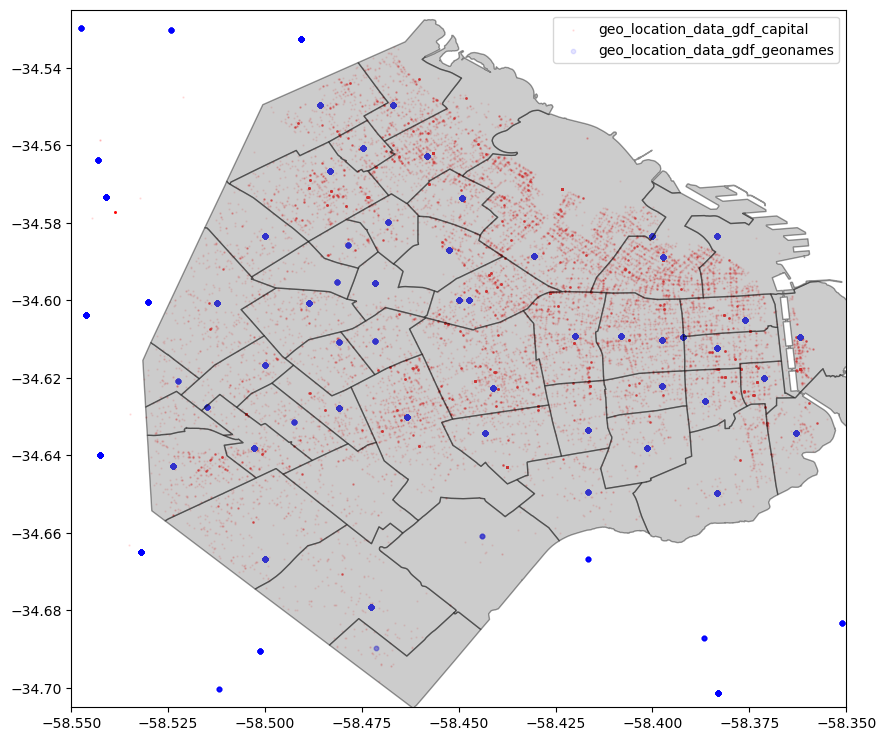

In [98]:
# Ubicamos los puntos en el mapa

# Estos df ya fueron creado y están puestos como referencia
# geo_location_data_gdf = gpd.GeoDataFrame(geo_location_data, geometry=gpd.points_from_xy(geo_location_data.lon, geo_location_data.lat))
# geo_location_data_gdf_capital = geo_location_data_gdf[data['state_name']=='Capital Federal']


geo_location_data_gdf_geonames = gpd.GeoDataFrame(geo_location_data_geonames_vs_latlon, geometry=gpd.points_from_xy(geo_location_data_geonames_vs_latlon.lon_geoname, geo_location_data_geonames_vs_latlon.lat_geoname))
df_barrios_capital = pd.read_csv('./data/barrios.csv', sep=',', encoding='latin-1')


df_barrios_capital["WKT"] = df_barrios_capital["WKT"].apply(shapely.wkt.loads) 
df_barrios_capital = gpd.GeoDataFrame(df_barrios_capital, geometry='WKT')

fig, ax = plt.subplots(figsize=(10,20))

geo_location_data_gdf_capital.plot(ax=ax, markersize=0.5, color='red', alpha=0.1, legend=True)
geo_location_data_gdf_geonames.plot(ax=ax, markersize=10, color='blue', alpha=0.1, legend=True)
df_barrios_capital.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
plt.legend(['geo_location_data_gdf_capital', 'geo_location_data_gdf_geonames', 'df_barrios_capital'])
plt.xlim(-58.55,-58.350)
plt.ylim(-34.705,-34.525) 
plt.show()

*Conclusión: Geonames_id marca el centro de cada uno de los barrios y no la latitud y longitud exacta de la propiedad. Por lo que deberíamos imputar lat y lon a partir de geonames_id con mucho cuidado.*

#### Corroborar si lat-lon coincide con place_name

In [99]:
municipios_geo.head()

,gid,objeto,fna,gna,nam,in1,fdc,sag,geometry
0,470,Municipio,Municipio Loreto,Municipio,Loreto,540077,Ministerio de Ecología,IGN,"POLYGON ((-55.44698 -27.39184, -55.44724 -27.3..."
1,730,Municipio,Comuna Angeloni,Comuna,Angeloni,823862,Servicio de Catastro e Información Territorial,IGN,"POLYGON ((-60.67225 -30.74442, -60.67913 -30.7..."
2,99,Municipio,Municipio Campana,Municipio,Campana,060126,ARBA - Gerencia de Servicios Catastrales,IGN,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."
3,33,Municipio,Municipio El Huecú,Municipio,El Huecú,580182,Direc. Pcial. de Catastro e Inf. Territorial,IGN,"POLYGON ((-70.54255 -37.65973, -70.54988 -37.6..."
4,939,Municipio,Municipio Calilegua,Municipio,Calilegua,380126,Direc. Grl. de Catastro,IGN,"POLYGON ((-64.85258 -23.62648, -64.84967 -23.6..."


In [100]:
municipios_geo_nam_geo = municipios_geo.copy()

In [101]:
# Reemplazamos ciudades por municipios
places_data_4_elements_with_mun_as_place_name = places_data_4_elements.copy()
places_data_4_elements_with_mun_as_place_name['place_name'] = places_data_4_elements['place_with_parent_names'].apply(lambda x: x[2])
print(places_data_4_elements_with_mun_as_place_name.shape)
places_data_4_elements_with_mun_as_place_name.head()

(39869, 4)


,place_name,place_with_parent_names,country_name,state_name
4,Mar del Plata,"[Argentina, Buenos Aires Costa Atlántica, Mar ...",Argentina,Buenos Aires Costa Atlántica
6,Vicente López,"[Argentina, Bs.As. G.B.A. Zona Norte, Vicente ...",Argentina,Bs.As. G.B.A. Zona Norte
12,San Isidro,"[Argentina, Bs.As. G.B.A. Zona Norte, San Isid...",Argentina,Bs.As. G.B.A. Zona Norte
13,Palermo,"[Argentina, Capital Federal, Palermo, Palermo ...",Argentina,Capital Federal
14,Palermo,"[Argentina, Capital Federal, Palermo, Palermo ...",Argentina,Capital Federal


In [102]:
# Unimos los nuevos municipios asignados con los otro municipios
places_data_mun = pd.concat([places_data_4_elements_with_mun_as_place_name, places_data_3_elements], axis=0) 
print(places_data_mun.shape) 
places_data_mun.head() 

(115892, 4)


,place_name,place_with_parent_names,country_name,state_name
4,Mar del Plata,"[Argentina, Buenos Aires Costa Atlántica, Mar ...",Argentina,Buenos Aires Costa Atlántica
6,Vicente López,"[Argentina, Bs.As. G.B.A. Zona Norte, Vicente ...",Argentina,Bs.As. G.B.A. Zona Norte
12,San Isidro,"[Argentina, Bs.As. G.B.A. Zona Norte, San Isid...",Argentina,Bs.As. G.B.A. Zona Norte
13,Palermo,"[Argentina, Capital Federal, Palermo, Palermo ...",Argentina,Capital Federal
14,Palermo,"[Argentina, Capital Federal, Palermo, Palermo ...",Argentina,Capital Federal


In [103]:
# Unimos los municipios con su georeferencia
places_data_mun_geo = places_data_mun.join(geo_location_data)
print(places_data_mun_geo.shape)
places_data_mun_geo.head()

(115892, 10)


,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,lat_geoname,lon_geoname
4,Mar del Plata,"[Argentina, Buenos Aires Costa Atlántica, Mar ...",Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,NaN,NaN
6,Vicente López,"[Argentina, Bs.As. G.B.A. Zona Norte, Vicente ...",Argentina,Bs.As. G.B.A. Zona Norte,3430511.0,"-34.5329567,-58.5217825",-34.532957,-58.521782,-34.53021,-58.52421
12,San Isidro,"[Argentina, Bs.As. G.B.A. Zona Norte, San Isid...",Argentina,Bs.As. G.B.A. Zona Norte,3430813.0,"-34.4860195,-58.5038139",-34.486019,-58.503814,-34.49397,-58.51679
13,Palermo,"[Argentina, Capital Federal, Palermo, Palermo ...",Argentina,Capital Federal,3430234.0,NaN,NaN,NaN,-34.58856,-58.43053
14,Palermo,"[Argentina, Capital Federal, Palermo, Palermo ...",Argentina,Capital Federal,3430234.0,NaN,NaN,NaN,-34.58856,-58.43053


In [104]:
# Lo convertimos en geo data frame
places_data_mun_geo_gdf = gpd.GeoDataFrame(places_data_mun_geo, geometry=gpd.points_from_xy(places_data_mun_geo.lon, places_data_mun_geo.lat))
places_data_mun_geo_gdf.head()

,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,lat_geoname,lon_geoname,geometry
4,Mar del Plata,"[Argentina, Buenos Aires Costa Atlántica, Mar ...",Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,NaN,NaN,POINT (-57.54945 -38.00263)
6,Vicente López,"[Argentina, Bs.As. G.B.A. Zona Norte, Vicente ...",Argentina,Bs.As. G.B.A. Zona Norte,3430511.0,"-34.5329567,-58.5217825",-34.532957,-58.521782,-34.53021,-58.52421,POINT (-58.52178 -34.53296)
12,San Isidro,"[Argentina, Bs.As. G.B.A. Zona Norte, San Isid...",Argentina,Bs.As. G.B.A. Zona Norte,3430813.0,"-34.4860195,-58.5038139",-34.486019,-58.503814,-34.49397,-58.51679,POINT (-58.50381 -34.48602)
13,Palermo,"[Argentina, Capital Federal, Palermo, Palermo ...",Argentina,Capital Federal,3430234.0,NaN,NaN,NaN,-34.58856,-58.43053,POINT EMPTY
14,Palermo,"[Argentina, Capital Federal, Palermo, Palermo ...",Argentina,Capital Federal,3430234.0,NaN,NaN,NaN,-34.58856,-58.43053,POINT EMPTY


In [105]:
# limpiamos los datos que no tienen georeferencia
places_data_mun_geo_gdf.dropna(subset=['lat', 'lon'], inplace=True)
places_data_mun_geo_gdf = places_data_mun_geo_gdf[['place_name', 'geometry','state_name']]
print(places_data_mun_geo_gdf.shape)
places_data_mun_geo_gdf.head()

(67788, 3)


,place_name,geometry,state_name
4,Mar del Plata,POINT (-57.54945 -38.00263),Buenos Aires Costa Atlántica
6,Vicente López,POINT (-58.52178 -34.53296),Bs.As. G.B.A. Zona Norte
12,San Isidro,POINT (-58.50381 -34.48602),Bs.As. G.B.A. Zona Norte
15,San Miguel,POINT (-58.69878 -34.58791),Bs.As. G.B.A. Zona Norte
24,Morón,POINT (-58.64386 -34.65111),Bs.As. G.B.A. Zona Oeste


In [106]:
# convertimos a coordenadas geográficas para poder hacer el join con el geodataframe de las propiedades.
places_data_mun_geo_gdf.crs = "EPSG:4326" 
places_data_mun_geo_gdf = places_data_mun_geo_gdf.to_crs("EPSG:4326")

In [107]:
# unimos los municipios con su georeferencia con los municipios con su georeferencia de places_data_mun_geo_gdf
common_municipios = gpd.sjoin(municipios_geo_nam_geo, places_data_mun_geo_gdf, how="inner")
common_municipios = common_municipios[['nam','fna', 'place_name','state_name', 'geometry']]
print(common_municipios.shape)
common_municipios.head()

(67450, 5)


,nam,fna,place_name,state_name,geometry
2,Campana,Municipio Campana,Campana,Buenos Aires Interior,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."
2,Campana,Municipio Campana,Campana,Buenos Aires Interior,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."
2,Campana,Municipio Campana,Campana,Buenos Aires Interior,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."
2,Campana,Municipio Campana,Campana,Buenos Aires Interior,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."
2,Campana,Municipio Campana,Campana,Buenos Aires Interior,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."


In [108]:
# Chequeamos que nam y place_name sean iguales
(common_municipios['nam'] == common_municipios['place_name']).sum() == common_municipios.shape[0] 


False

In [109]:
# Vemos que municipios que coinciden con place_name
common_municipios[common_municipios['nam'] == common_municipios['place_name']]

,nam,fna,place_name,state_name,geometry
2,Campana,Municipio Campana,Campana,Buenos Aires Interior,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."
2,Campana,Municipio Campana,Campana,Buenos Aires Interior,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."
2,Campana,Municipio Campana,Campana,Buenos Aires Interior,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."
2,Campana,Municipio Campana,Campana,Buenos Aires Interior,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."
2,Campana,Municipio Campana,Campana,Buenos Aires Interior,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."
...,...,...,...,...,...
1780,Paso de la Patria,Municipio Paso de la Patria,Paso de la Patria,Corrientes,"MULTIPOLYGON (((-58.48330 -27.29400, -58.47461..."
1780,Paso de la Patria,Municipio Paso de la Patria,Paso de la Patria,Corrientes,"MULTIPOLYGON (((-58.48330 -27.29400, -58.47461..."
1780,Paso de la Patria,Municipio Paso de la Patria,Paso de la Patria,Corrientes,"MULTIPOLYGON (((-58.48330 -27.29400, -58.47461..."
1796,Corrientes,Municipio Corrientes,Corrientes,Corrientes,"POLYGON ((-58.69498 -27.38300, -58.69429 -27.3..."


In [110]:
# Vemos que municipios que no coinciden con place_name
common_municipios[common_municipios['nam'] != common_municipios['place_name']]

,nam,fna,place_name,state_name,geometry
22,San Carlos de Bariloche,Municipio San Carlos de Bariloche,Villa Llao Llao,Río Negro,"POLYGON ((-71.75268 -41.02185, -71.74829 -41.0..."
31,San Javier,Comuna San Javier,San Miguel de Tucumán,Tucumán,"POLYGON ((-65.42743 -26.71029, -65.42689 -26.7..."
44,Alta Gracia,Municipio Alta Gracia,Córdoba,Córdoba,"POLYGON ((-64.54288 -31.59608, -64.54312 -31.5..."
44,Alta Gracia,Municipio Alta Gracia,Córdoba,Córdoba,"POLYGON ((-64.54288 -31.59608, -64.54312 -31.5..."
47,Juana Koslay,Municipio Juana Koslay,San Luis,San Luis,"POLYGON ((-66.21014 -33.24077, -66.21500 -33.2..."
...,...,...,...,...,...
1758,Comuna 12,Comuna 12,Villa Pueyrredón,Capital Federal,"POLYGON ((-58.46805 -34.57293, -58.46825 -34.5..."
1758,Comuna 12,Comuna 12,Villa Pueyrredón,Capital Federal,"POLYGON ((-58.46805 -34.57293, -58.46825 -34.5..."
1758,Comuna 12,Comuna 12,Villa Pueyrredón,Capital Federal,"POLYGON ((-58.46805 -34.57293, -58.46825 -34.5..."
1758,Comuna 12,Comuna 12,Villa Pueyrredón,Capital Federal,"POLYGON ((-58.46805 -34.57293, -58.46825 -34.5..."


In [111]:
# Considerando que el patrón Comuna n es de Capital Federal, eliminamos las filas que tenga ese patrón y el state_name sea Capital Federal
regex_comuna = r'Comuna \d+'
common_municipios = common_municipios[ ~((common_municipios['nam'].str.contains(regex_comuna)) & (common_municipios['state_name'] == 'Capital Federal'))]
print(common_municipios.shape)
uncommon_municipios = common_municipios[common_municipios['nam'] != common_municipios['place_name']]
print(uncommon_municipios.shape)
uncommon_municipios.head()

(44327, 5)
(9266, 5)


,nam,fna,place_name,state_name,geometry
22,San Carlos de Bariloche,Municipio San Carlos de Bariloche,Villa Llao Llao,Río Negro,"POLYGON ((-71.75268 -41.02185, -71.74829 -41.0..."
31,San Javier,Comuna San Javier,San Miguel de Tucumán,Tucumán,"POLYGON ((-65.42743 -26.71029, -65.42689 -26.7..."
44,Alta Gracia,Municipio Alta Gracia,Córdoba,Córdoba,"POLYGON ((-64.54288 -31.59608, -64.54312 -31.5..."
44,Alta Gracia,Municipio Alta Gracia,Córdoba,Córdoba,"POLYGON ((-64.54288 -31.59608, -64.54312 -31.5..."
47,Juana Koslay,Municipio Juana Koslay,San Luis,San Luis,"POLYGON ((-66.21014 -33.24077, -66.21500 -33.2..."


In [112]:
print("Municipios diferentes: ", uncommon_municipios['nam'].nunique())
uncommon_municipios['place_name'].value_counts().head()

Municipios diferentes:  222


Mar del Plata    6248
Punilla           312
Confluencia       146
Córdoba           138
José C Paz        130
Name: place_name, dtype: int64

In [113]:
uncommon_municipios_mar_del_plata = uncommon_municipios[uncommon_municipios['place_name'] == 'Mar del Plata'] 
print(uncommon_municipios_mar_del_plata.shape) 
uncommon_municipios_mar_del_plata.head()

(6248, 5)


,nam,fna,place_name,state_name,geometry
103,General Pueyrredón,Municipio General Pueyrredón,Mar del Plata,Buenos Aires Costa Atlántica,"POLYGON ((-57.67326 -37.74815, -57.67356 -37.7..."
103,General Pueyrredón,Municipio General Pueyrredón,Mar del Plata,Buenos Aires Costa Atlántica,"POLYGON ((-57.67326 -37.74815, -57.67356 -37.7..."
103,General Pueyrredón,Municipio General Pueyrredón,Mar del Plata,Buenos Aires Costa Atlántica,"POLYGON ((-57.67326 -37.74815, -57.67356 -37.7..."
103,General Pueyrredón,Municipio General Pueyrredón,Mar del Plata,Buenos Aires Costa Atlántica,"POLYGON ((-57.67326 -37.74815, -57.67356 -37.7..."
103,General Pueyrredón,Municipio General Pueyrredón,Mar del Plata,Buenos Aires Costa Atlántica,"POLYGON ((-57.67326 -37.74815, -57.67356 -37.7..."


In [114]:
# Mar del Plata corresponde al municipio de General Pueyrredón, por lo que también lo eliminamos.
common_municipios = common_municipios[ ~((common_municipios['nam'] == 'General Pueyrredón') & (common_municipios['place_name'] == 'Mar del Plata'))]
print(common_municipios.shape)
uncommon_municipios = common_municipios[common_municipios['nam'] != common_municipios['place_name']]
print(uncommon_municipios.shape)
uncommon_municipios.head()

(38094, 5)
(3033, 5)


,nam,fna,place_name,state_name,geometry
22,San Carlos de Bariloche,Municipio San Carlos de Bariloche,Villa Llao Llao,Río Negro,"POLYGON ((-71.75268 -41.02185, -71.74829 -41.0..."
31,San Javier,Comuna San Javier,San Miguel de Tucumán,Tucumán,"POLYGON ((-65.42743 -26.71029, -65.42689 -26.7..."
44,Alta Gracia,Municipio Alta Gracia,Córdoba,Córdoba,"POLYGON ((-64.54288 -31.59608, -64.54312 -31.5..."
44,Alta Gracia,Municipio Alta Gracia,Córdoba,Córdoba,"POLYGON ((-64.54288 -31.59608, -64.54312 -31.5..."
47,Juana Koslay,Municipio Juana Koslay,San Luis,San Luis,"POLYGON ((-66.21014 -33.24077, -66.21500 -33.2..."


In [115]:
uncommon_municipios.groupby([ 'nam','place_name']).count().sort_values(by='state_name', ascending=False).head(10)

fna  state_name  geometry
nam              place_name                                   
Villa Carlos Paz Punilla             138         138       138
Neuquén          Confluencia         128         128       128
José C. Paz      José C Paz          127         127       127
La Costa         San Bernardo        111         111       111
General Alvarado Miramar             100         100       100
Rafaela          Castellanos          95          95        95
La Costa         Costa Esmeralda      81          81        81
                 Mar de Ajó           70          70        70
Ezeiza           Esteban Echeverría   56          56        56
Funes            Rosario              49          49        49

*Conclusión: Los datos de lat-lon coinciden con place_name.*

Casos notables: 
- Capital Federal: según el df del IGN son comunas y según el original son barrios. Se asume que son correctos.
- Mar del Plata: Mar del Plata es la ciudad y General Pueyrredón el municipio. Si se utiliza el municipio como place_name lo correcto es imputarlo. # https://www.argentina.gob.ar/buenosaires/municipios

#### Analizar si es posible imputar place_name de los registros deplaces_data_2_elements(donde solo hay país y provincia)

In [116]:
# Unimos los municipios con su georeferencia
places_data_2_elements_geo = places_data_2_elements.join(geo_location_data)  
print(places_data_2_elements_geo.shape)
places_data_2_elements_geo.head()

(4780, 10)


,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,lat_geoname,lon_geoname
108,Capital Federal,"[Argentina, Capital Federal]",Argentina,Capital Federal,3433955.0,NaN,NaN,NaN,-34.6,-58.45
110,Capital Federal,"[Argentina, Capital Federal]",Argentina,Capital Federal,3433955.0,NaN,NaN,NaN,-34.6,-58.45
115,Capital Federal,"[Argentina, Capital Federal]",Argentina,Capital Federal,3433955.0,NaN,NaN,NaN,-34.6,-58.45
119,Capital Federal,"[Argentina, Capital Federal]",Argentina,Capital Federal,3433955.0,NaN,NaN,NaN,-34.6,-58.45
121,Capital Federal,"[Argentina, Capital Federal]",Argentina,Capital Federal,3433955.0,NaN,NaN,NaN,-34.6,-58.45


In [117]:
# Vemos si existe geonames_id en alguna fila en places_data_2_elements_geo
places_data_2_elements_geo['geonames_id'].isnull().sum() == places_data_2_elements_geo.shape[0]  

False

In [118]:
# Vemos si existe lat y lon en alguna fila en places_data_2_elements_geo
places_data_2_elements_geo['lat'].isnull().sum() == places_data_2_elements_geo.shape[0]  and places_data_2_elements_geo['lon'].isnull().sum() == places_data_2_elements_geo.shape[0]

False

*Conclusión: No es posible imputar place_name en los registros donde place name es una provincia a partir de su georeferencia*

### Superficie

Vemos como están representados los datos se superfice total y superficie cubierta para los cuatro tipos de propiedades

In [119]:
#Creamos una copia de data para trabajar con ella
data_superficie = data.copy()

In [120]:
#Revisamos los datos nulos de cada columna 
data_superficie[["surface_covered_in_m2", "surface_total_in_m2" ]].isna().sum()
#vemos que surface_total_in_m2 tiene un mayor contenido de datos nulos. 
#de aplicar description() sobre el dataset vimos que existian valores extremos en ambas variables

surface_covered_in_m2    19907
surface_total_in_m2      39328
dtype: int64

#### 1- Recuperación de informacion faltante en la variable de referencia aplicando regex a la columna descripción

In [121]:
#se aplica regex a la columna descripción, buscando las palabras metros, mts y m2 precedido de dígitos. 
serie_descripcion = data_superficie["description"]

pattern_sup_m2 = "(?P<sup>\d{2,}(,|.\d+)?)\s*(m2|metros|mts)"
pattern_sup_m2_regex = re.compile(pattern_sup_m2,  re.IGNORECASE)

sup_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex.search(x))
mask_sup_match_notnull= sup_match.notnull()

data_superficie.loc[mask_sup_match_notnull, "Sup_m2_Clean"] = sup_match[mask_sup_match_notnull].apply(lambda x: x.group("sup"))

In [122]:
print(data_superficie[["Sup_m2_Clean"]].sample(16))
print("---------------------")
print("Datos recuperados:", data_superficie[["Sup_m2_Clean"]].notna().sum())

       Sup_m2_Clean
115082          NaN
94703           NaN
37208           NaN
27154           NaN
107823          NaN
107598          NaN
90771            90
49559           NaN
43295            33
29833           NaN
76508           NaN
99303           NaN
73985           NaN
66769           NaN
90196            50
116297          NaN
---------------------
Datos recuperados: Sup_m2_Clean    40087
dtype: int64


In [123]:
# Al analizar la información se detecta errores de formato (algunos puntos y comas), no posibles de salvaguardar usando los métodos replace o to_numeric, 
# por lo cual se decide aplicar nuevamente regex para sacar la partes enteras de los números, lo cual nos permitirá poder usar esta información 
# en estadísticas mas adelante.
serie_sup_m2_clean=data_superficie["Sup_m2_Clean"]

pattern_sup_m2_dos="(?P<supdos>\d{2,})"
pattern_sup_m2_regex_dos=re.compile(pattern_sup_m2_dos)
sup_match_dos = serie_sup_m2_clean.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex_dos.search(x))
mask_sup_match_notnull_dos= sup_match_dos.notnull()
data_superficie.loc[mask_sup_match_notnull_dos, "Sup_m2_Clean_dos"] = sup_match_dos[mask_sup_match_notnull_dos].apply(lambda x: x.group("supdos"))


In [124]:
#se verifica información obtenida con regex
data_superficie[["surface_total_in_m2", "surface_covered_in_m2", "Sup_m2_Clean_dos"]].sample(20)

,surface_total_in_m2,surface_covered_in_m2,Sup_m2_Clean_dos
52921,800.0,245.0,245
23388,NaN,35.0,35
84473,132.0,62.0,NaN
76039,176.0,176.0,NaN
76030,NaN,147.0,NaN
116862,83.0,69.0,69
58951,NaN,750.0,230
68850,NaN,NaN,NaN
80697,NaN,116.0,NaN
31083,46.0,46.0,NaN


In [125]:
#se revisan datos que son mayores a 10000 m2 y que impactarían en el modelo al reemplazar la superficie total.
data_superficie["Sup_m2_Clean_dos"]=pd.to_numeric(data_superficie["Sup_m2_Clean_dos"])
mask_consistencia_regex= (data_superficie["Sup_m2_Clean_dos"] > 10000) & (data_superficie["surface_total_in_m2"].isnull())
consistencia_regex=data_superficie[mask_consistencia_regex]
consistencia_regex[["surface_total_in_m2", "surface_covered_in_m2", "Sup_m2_Clean_dos"]]

,surface_total_in_m2,surface_covered_in_m2,Sup_m2_Clean_dos
13157,NaN,20.0,420158.0
21499,NaN,250.0,2018250.0
22057,NaN,55.0,48000.0
41002,NaN,NaN,11900.0
41113,NaN,NaN,420180.0
45514,NaN,136.0,3200136.0
49535,NaN,NaN,80000.0
50780,NaN,NaN,20000.0
59081,NaN,380.0,12441.0
59532,NaN,NaN,12000.0


In [126]:
consistencia_regex.shape

(17, 27)

In [127]:
#se decide eliminar los valores analizados por ser estos incoherentes, e impactarían como outliers en los análisis posteriores.
data_superficie["Sup_m2_Clean_tres"]=data_superficie["Sup_m2_Clean_dos"].copy()

data_superficie.loc[mask_consistencia_regex,"Sup_m2_Clean_tres"] = 0



> Durante la imputación se podrá corroborar el aporte de la información recuperada
> ___

#### 2- Revisión la coherencia entre las columnas Superficie total y superficie cubierta.

In [128]:
#se verifican valores de superficie total vs superficie cubierta, entendiendo que la primera siempre debe ser mayor que la segunda.
mask_consistencia_sup = data_superficie["surface_total_in_m2"] < data_superficie["surface_covered_in_m2"]
data_superficie[mask_consistencia_sup].shape

(1106, 28)

*Se detectan 1106 valores cuya superficie total es menor que la superficie cubierta, siendo esto inconsistente.*

Se revisa el contenido de las columnas comparandolas entre si, ademas se la compara con la informacion obtenida en descripcion para comprobar coherencia de los datos

In [129]:
data_consistencia_sup = data_superficie[mask_consistencia_sup]
data_consistencia_sup[["surface_total_in_m2","surface_covered_in_m2","Sup_m2_Clean_dos", "property_type"]].sample(20)

,surface_total_in_m2,surface_covered_in_m2,Sup_m2_Clean_dos,property_type
97278,42.0,45.0,45.0,apartment
107088,42.0,90.0,NaN,apartment
82725,60.0,70.0,NaN,apartment
26554,31.0,32.0,80.0,apartment
120124,20.0,120.0,NaN,apartment
41943,200.0,300.0,NaN,house
2876,400.0,500.0,NaN,store
52291,200.0,204.0,10.0,house
6891,113.0,120.0,120.0,house
34039,70.0,110.0,NaN,house


In [130]:
#se analiza la consistencia de los datos para valores de superficie mayores a 1000m2
mascara_coherencia_sup = data_superficie["surface_covered_in_m2"] >= 1000
data_coherencia_sup = data_superficie [mascara_coherencia_sup]
data_coherencia_sup [["surface_total_in_m2","surface_covered_in_m2","Sup_m2_Clean_dos", "rooms","property_type"]]

,surface_total_in_m2,surface_covered_in_m2,Sup_m2_Clean_dos,rooms,property_type
78,261.0,18615.0,NaN,5.0,house
525,7500.0,1800.0,7500.0,NaN,house
3325,3700.0,3500.0,NaN,5.0,house
3762,1200.0,1200.0,200.0,3.0,house
3767,7500.0,1000.0,500.0,1.0,apartment
...,...,...,...,...,...
119253,NaN,1000.0,70.0,6.0,apartment
119355,NaN,1300.0,NaN,18.0,apartment
119935,NaN,12731.0,NaN,10.0,house
120302,1200.0,12000.0,3500.0,NaN,house


In [131]:
data_coherencia_sup.shape

(425, 28)

Para valores mayores a 1000m2, 39 filas, los valores en la columna superficie total son mas coherente que los datos de superficie cubierta, motivo por el cual en este caso no se modificará la variable

In [132]:
# se hace mismo análisis par superficies menores a 1000m2
mascara_coherencia_sup_menor = data_superficie["surface_covered_in_m2"] <1000
data_coherencia_sup_menor = data_consistencia_sup [mascara_coherencia_sup_menor]
data_coherencia_sup_menor [["surface_total_in_m2","surface_covered_in_m2","Sup_m2_Clean_dos", "rooms","property_type"]].sample(10)

C:\Users\LuisD\AppData\Local\Temp\ipykernel_16016\2316273039.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_coherencia_sup_menor = data_consistencia_sup [mascara_coherencia_sup_menor]


,surface_total_in_m2,surface_covered_in_m2,Sup_m2_Clean_dos,rooms,property_type
17636,44.0,48.0,NaN,2.0,apartment
52779,134.0,200.0,NaN,NaN,house
38589,90.0,200.0,NaN,NaN,house
73668,48.0,52.0,NaN,NaN,apartment
16962,151.0,169.0,NaN,NaN,house
119787,44.0,60.0,NaN,NaN,apartment
13610,298.0,300.0,NaN,NaN,house
41820,32.0,40.0,32.0,1.0,apartment
64815,250.0,520.0,NaN,NaN,house
41977,40.0,42.0,NaN,NaN,apartment


> Para superficies cubiertas menores a 1000m2 la columna superficie cubierta posee valores mas razonables, valores que podrán luego imputarse para obtener un modelo mas preciso.
> ___

#### 3- Detección de outliers de la variable Superficie.

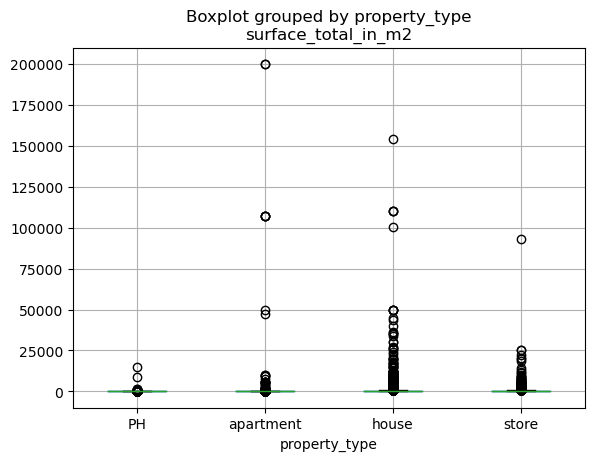

In [133]:
#se grafica la informacion de superficie por tipo de propiedad para visualizar los outliers
data_superficie.boxplot(column= "surface_total_in_m2", by="property_type") 
plt.show()

In [134]:
data_superficie["surface_total_in_m2"].describe()

count     81892.000000
mean        233.795328
std        1782.222147
min           0.000000
25%          50.000000
50%          84.000000
75%         200.000000
max      200000.000000
Name: surface_total_in_m2, dtype: float64

In [135]:
outlier_value = 10000
mask_consistencia_outlier_sup= data_superficie["surface_total_in_m2"] >= outlier_value
data_superficie[mask_consistencia_outlier_sup].shape

(87, 28)

Se analiza el contenido de las columnas para corroborar coherencia.

In [136]:
data_consistencia_outliers = data_superficie[mask_consistencia_outlier_sup]
data_consistencia_outliers[["surface_total_in_m2","surface_covered_in_m2"]].sample(10)

,surface_total_in_m2,surface_covered_in_m2
59165,10000.0,215.0
35226,100350.0,350.0
18987,15000.0,650.0
24586,16717.0,NaN
45653,14000.0,181.0
53972,26536.0,217.0
86665,107000.0,80.0
69115,10958.0,10958.0
71991,49700.0,300.0
4851,11700.0,415.0


> Del análisis de las columnas donde existen outliers se detecta que los valores que se encuentran en la columna en superficie cubierta son mas coherentes que los de la columna superficie total, por lo cual, se decide para estas 87 columnas imputar el valor superficie cubierta como superficie total y revisar nuevamente outliers. Ver en apartado *"IMPUTACION"*
> ___

##### 4- Se supone que la superficie cubierta es la misma que la superficie total.

In [137]:
data_superficie['sup_m2_total_limpia']= pd.to_numeric(data_superficie['surface_total_in_m2'])
data_superficie['coef_ajuste_m2']=np.where(data_superficie['surface_covered_in_m2'].notnull(),data_superficie['sup_m2_total_limpia']/data_superficie['surface_covered_in_m2'],np.NaN)

In [138]:
data_superficie.coef_ajuste_m2.sample(5)

112179         NaN
56188     1.000000
61483          NaN
27133     1.000000
13764     1.076923
Name: coef_ajuste_m2, dtype: float64

In [139]:
#Ahora los agrupo por groupby
fill_values_m2=data_superficie.groupby('property_type').coef_ajuste_m2.median()

In [140]:
fill_values_m2_df=pd.DataFrame(fill_values_m2)
fill_values_m2_df.reset_index(inplace=True)
fill_values_m2_df.head(5)

,property_type,coef_ajuste_m2
0,PH,1.184211
1,apartment,1.092593
2,house,1.250000
3,store,1.000000


Se identifica un coeficiente de ajuste para lograr comparar la superficie cubierta con la toal, que ayudará luego a imputar los valores de superficie cubierta ajustados a los faltantes en superficie total

### Ambientes

##### 1- Intentamos ver si los datos faltantes de rooms disminuyen si descontamos las tiendas

In [141]:
data_ambientes = data.copy()
mask_residencial= data_ambientes.property_type != 'store'
tipos_residenciales=data_ambientes.property_type[mask_residencial]
rooms_residenciales=data_ambientes.rooms[mask_residencial]
df_residencial=pd.DataFrame(tipos_residenciales)
df_residencial['rooms']=rooms_residenciales

In [142]:
data_ambientes.rooms.value_counts()

3.0     12567
2.0     12433
4.0      7937
1.0      7377
5.0      3782
6.0      1403
7.0       770
8.0       409
10.0      226
9.0       184
11.0       72
12.0       65
13.0       33
14.0       27
15.0       26
17.0       16
16.0       11
20.0       11
22.0        8
18.0        6
21.0        5
19.0        4
30.0        4
25.0        4
32.0        3
23.0        2
24.0        1
31.0        1
29.0        1
27.0        1
28.0        1
Name: rooms, dtype: int64

In [143]:
shape_df=df_residencial.shape
count_res=shape_df[0]

In [144]:
nulos_room=df_residencial.rooms.isna().sum(axis=0)
pctje_nulos_rooms=nulos_room/count_res
pctje_nulos_rooms

0.5961446482867001

Veamos cuantas rooms tienen las tiendas

In [145]:
mask_comercial= data_ambientes.property_type == 'store'
tipos_comerciales=data_ambientes.property_type[mask_comercial]
rooms_comerciales=data_ambientes.rooms[mask_comercial]
df_comercial=pd.DataFrame(tipos_comerciales)
df_comercial['rooms']=rooms_comerciales
df_comercial.rooms.value_counts()

1.0     55
2.0     17
3.0     13
7.0      6
4.0      4
5.0      4
10.0     3
6.0      2
8.0      1
Name: rooms, dtype: int64

Recordemos que el porcentaje original de nulos era similar, por lo que el quitar store del analisis no implicaria la disminución de los valores faltantes

Probemos ahora sacando los nulos de rooms para tratar de aplicar un promedio del tamaño de las rooms

In [146]:
mask_rooms_no_nulas=data_ambientes.rooms.notnull()
rooms_no_nulas=data_ambientes.rooms.loc[mask_rooms_no_nulas]
sf_room_no_nulas=data_ambientes.surface_covered_in_m2.loc[mask_rooms_no_nulas]
df_rooms_clean=pd.DataFrame(rooms_no_nulas)
df_rooms_clean['m2_covered']=sf_room_no_nulas
mask_rooms_no_nulas.value_counts()

False    73830
True     47390
Name: rooms, dtype: int64

El porcentaje de m2 cubiertos es ligeramente menor, por lo que no hay mucha correlacion entre nulidad de rooms y nulidad de m2_covered

#### 2-Se extrae información con regex de la columna descripción

In [147]:
## Arranco por los monoambientes
#pattern_mono='(?P<sup>\d{2,}(,|.\d+)?)\s*(mono)\S+?'
pattern_mono='(mono)|(mono\s+\w+)|(mono\.+\w+)|(mono\-+\w+)|(mono\w+)'
pattern_mono_regex=re.compile(pattern_mono,re.IGNORECASE)

In [148]:
serie_mono_descripcion=data_ambientes['description']
mono_match = serie_mono_descripcion.apply(lambda x: x if x is np.NaN else pattern_mono_regex.search(x))
#sup_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex.search(x))


In [149]:
mask_mono_match=mono_match.notnull()
col_mono_prueba_nulos=mono_match[mask_mono_match]
col_mono_prueba_nulos.shape

(10749,)

In [150]:
data_ambientes.loc[mask_mono_match,'Ambientes_Clean']= 1

Ahora me enfoco en todos los departamentos que no sean monos, uso por ahora ambientes, para evitar confusiones con dormitorios y habitaciones

In [151]:
#pattern_rooms= "(?P<dorm>\d+.?Dorm|\d+.?dorm|\d+.?DORM|\d+.?AMB|\d+.?Amb|\d+.?amb|\d+.?hab|\d+.?HAB|\d+.?Hab|monoamb)"
#pattern_rooms= "(?P<dorm>\d{2,}(,|.\d+)?)\s*(Dorm|amb|monoamb).?Dorm|\d+.?dorm|\d+.?DORM|\d+.?AMB|\d+.?Amb|\d+.?amb|\d+.?hab|\d+.?HAB|\d+.?Hab|monoamb)"
#"(?P<sup>\d{2,}(,|.\d+)?)\s*(m2|metros|mts)"(mono)|(mono\s+\w+)|(mono\.+\w+)|(mono\-+\w+)|(mono\w+)
#"(?P<sup>\d{2,}(,|.\d+)?)\s*(m2|metros|mts)"
pattern_ambs="(?P<num>\s\d{1,2})\s*(\samb\w*\s)"
pattern_ambs_regex=re.compile(pattern_ambs,re.IGNORECASE)

In [152]:
mask_mono_nulo=mono_match.isnull()
col_mono_nulo=mono_match[mask_mono_nulo]
pattern_ambs_match=serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_ambs_regex.search(x))

In [153]:
pattern_ambs_match.value_counts()

<re.Match object; span=(2, 15), match=' 3 ambientes '>        1
<re.Match object; span=(2, 9), match=' 3 amb '>               1
<re.Match object; span=(17, 30), match=' 2 ambientes '>       1
<re.Match object; span=(84, 97), match=' 3 ambientes '>       1
<re.Match object; span=(155, 169), match=' 2  ambientes '>    1
                                                             ..
<re.Match object; span=(117, 130), match=' 3 ambientes '>     1
<re.Match object; span=(118, 131), match=' 4 ambientes '>     1
<re.Match object; span=(129, 142), match=' 4 ambientes '>     1
<re.Match object; span=(223, 236), match=' 2 ambientes '>     1
<re.Match object; span=(577, 590), match=' 3 ambientes '>     1
Name: description, Length: 27506, dtype: int64

In [154]:
type(pattern_ambs_match)

pandas.core.series.Series

In [155]:
print(pattern_ambs_match.isna().sum())
print(pattern_ambs_match.notna().sum())

93714
27506


In [156]:
#Cambio los None por NaN
pattern_ambs_match_2=pattern_ambs_match.fillna(np.NaN)

In [157]:
pattern_ambs_match_3=pattern_ambs_match_2.apply(lambda x: x if x is np.NaN else x[0])

In [158]:
nuevo_pattern='(?P<num>\d{1,2})'
nuevo_pattern_regex=re.compile(nuevo_pattern)
nuevo_pattern_match=pattern_ambs_match_3.apply(lambda x: x if x is np.NaN else nuevo_pattern_regex.search(x))
nuevo_pattern_match.notnull().sum()

27506

In [159]:
mask_def_not_null= nuevo_pattern_match.notnull()
mask_mono_nulo=mono_match.isnull()
data_ambientes.loc[mask_mono_nulo, "Ambientes_Clean"] = nuevo_pattern_match[mask_mono_nulo].apply(lambda x: x if x is np.NaN else x.group('num'))


In [160]:
serie_rooms_clean=data_ambientes["Ambientes_Clean"]
serie_rooms_clean.notnull().sum()
serie_rooms_clean.value_counts()
data_ambientes[['Ambientes_Clean','rooms']].sample(10)

,Ambientes_Clean,rooms
64848,NaN,NaN
24579,NaN,4.0
34941,NaN,NaN
3203,NaN,3.0
105431,NaN,NaN
56638,1.0,1.0
68746,NaN,NaN
58067,NaN,NaN
28812,NaN,3.0
9425,NaN,3.0


In [161]:
mask_room_no_nula = data_ambientes.rooms.notnull()
data_ambientes.Ambientes_Clean[mask_room_no_nula]=data_ambientes.rooms[mask_room_no_nula]
data_ambientes[['Ambientes_Clean','rooms']][mask_room_no_nula]

C:\Users\LuisD\AppData\Local\Temp\ipykernel_16016\38736117.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ambientes.Ambientes_Clean[mask_room_no_nula]=data_ambientes.rooms[mask_room_no_nula]


,Ambientes_Clean,rooms
13,1.0,1.0
14,1.0,1.0
16,4.0,4.0
17,3.0,3.0
19,3.0,3.0
...,...,...
120203,2.0,2.0
120204,1.0,1.0
120205,5.0,5.0
120206,4.0,4.0


In [162]:
#Pctje no nulo de rooms
print(data_ambientes.Ambientes_Clean.notnull().sum()/data_ambientes.shape[0])
print(data_ambientes.rooms.notnull().sum()/data_ambientes.shape[0])

0.5491585546939449
0.3909420887642303


Recuperamos el 16% de rooms

#### 3- Se pretende estimar el tamaño mediano de ambientes

In [163]:
data_ambientes.Ambientes_Clean=data_ambientes.Ambientes_Clean.astype(float)

In [164]:
data_ambientes.surface_covered_in_m2=data_ambientes.surface_covered_in_m2.astype('Int64')
data_ambientes[['Ambientes_Clean','surface_covered_in_m2']].dtypes

Ambientes_Clean          float64
surface_covered_in_m2      Int64
dtype: object

In [165]:
data_ambientes['size_rooms']=np.where(data_ambientes['Ambientes_Clean'].notnull(),data_ambientes['surface_covered_in_m2']/data_ambientes['Ambientes_Clean'],np.NaN)

In [166]:
fill_values=data_ambientes.groupby('property_type').size_rooms.median()

In [167]:
fill_values_df=pd.DataFrame(fill_values)
fill_values_df.reset_index(inplace=True)
fill_values_df.head(5)

,property_type,size_rooms
0,PH,23.50
1,apartment,26.00
2,house,40.00
3,store,57.75


Se determino un tamaño mediano por tipo de propiedad que será imputado para la columna rooms

### Precio

#### 1-Extraer información con regex de columna descripción

In [168]:
#generamos una copia del archivo para no modificar archivo base
data_precio= data.copy()

In [169]:
#se pretende obtener información faltante en la columna precio, aplicando regex a la columna descripción, 
# suponiendo que los valores de precios que nos interesan son en dólares (usd, u$d) seguido de varios dígitos.
serie_descripcion = data_precio["description"]

pattern_usd = "(?P<usd>(usd|u[$]d)\s*?(\d{2,}(,|.\d+)?))"
pattern_usd_regex = re.compile(pattern_usd,  re.IGNORECASE)

usd_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_usd_regex.search(x))

mask_usd_match_notnull= usd_match.notnull()

data_precio.loc[mask_usd_match_notnull, "usd_clean"] = usd_match[mask_usd_match_notnull].apply(lambda x: x.group(0))

In [170]:
#la información obtenida posee caracteres no deseables por lo cual se vuelve a aplicar regex para poder dejar datos tipo float.
serie_usd_clean=data_precio["usd_clean"]
pattern_usd_dos="(?P<usddos>(\d{2,}(,|.\d+)?))"
pattern_usd_regex_dos=re.compile(pattern_usd_dos)
usd_match_dos = serie_usd_clean.apply(lambda x: x if x is np.NaN else pattern_usd_regex_dos.search(x))
mask_usd_match_notnull_dos= usd_match_dos.notnull()
data_precio.loc[mask_usd_match_notnull_dos, "usd_clean_dos"] = usd_match_dos[mask_usd_match_notnull_dos].apply(lambda x: x.group("usddos"))

#### 2-comprobar si las columnas precio ARS y USD pueden matchear

In [171]:
#se corrobora primero la cantidad de datos nullos de ambas columnas
#ademas se genera una mascara para corroborar si esos datos nulos coinciden, de manera tal que si lo hacen no se podrían matchear columnas.

mask_ARS_empty=data_precio["price_aprox_local_currency"].isnull()
mask_ARS_empty.value_counts()

False    100810
True      20410
Name: price_aprox_local_currency, dtype: int64

In [172]:
mask_USD_empty=data_precio["price_aprox_usd"].isnull()
mask_USD_empty.value_counts()

False    100810
True      20410
Name: price_aprox_usd, dtype: int64

In [173]:
#se aplica mascara para ambas condiciones antes presentadas.

mask_precio_empty=mask_ARS_empty&mask_USD_empty
data_precio[mask_precio_empty].shape

(20410, 27)

> coinciden la cantidad de filas vacias en cada campo, por lo cual no es posible completar completar datos vacios de USD con ARS sacados de la columna "price_aprox_local_currency"
> ___

# Minar los datos

### Dar formato, limpiar, homogeneizar y filtrar los datos

## Imputaciones ubicación

In [174]:
# Eliminamos las filas que no tienen municipio
data_clean_location = data.drop(index=places_data_2_elements_geo.index)
print(data_clean_location.shape)
data_clean_location.head()

(116440, 25)


,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


In [175]:
# Corroboramos que eliminamos nuestro outlier de Colombia
data_clean_location[data_clean_location['lat'] > 0]

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail


In [176]:
# Reemplazamos ciudades por municipios
data_clean_location.loc[places_data_4_elements_with_mun_as_place_name.index, 'place_name'] = places_data_4_elements_with_mun_as_place_name['place_name']
print(data_clean_location.shape)
data_clean_location.head()

(116440, 25)


,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,sell,apartment,Mar del Plata,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


In [177]:
# Elimino columnas con información duplicadas o innecesaria
unnecesary_columns = ['country_name', 'place_with_parent_names']
data_clean_location = data_clean_location.drop(columns=unnecesary_columns)
print(data_clean_location.shape) 
data_clean_location.head()

(116440, 23)


,operation,property_type,place_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,sell,PH,Mataderos,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,USD,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,sell,apartment,La Plata,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,sell,apartment,Mataderos,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,sell,PH,Liniers,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,95000.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,sell,apartment,Mar del Plata,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,64000.0,USD,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


In [178]:
# reutilizamos geo_location_data para obtener lat_geoname y lon_geoname
print(geo_location_data.shape)
geo_location_data.head(3)

(121220, 6)


,geonames_id,lat-lon,lat,lon,lat_geoname,lon_geoname
0,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,-34.66667,-58.5
1,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,-35.00000,-58.0
2,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,-34.66667,-58.5


In [179]:
# agregamos lat_geoname y lon_geoname a data_clean_location
data_clean_location['lat_geoname'] = geo_location_data['lat_geoname']
data_clean_location['lon_geoname'] = geo_location_data['lon_geoname']
print(data_clean_location.shape)
data_clean_location.head(3)

(116440, 25)


,operation,property_type,place_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,lat_geoname,lon_geoname
0,sell,PH,Mataderos,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,USD,...,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,-34.66667,-58.5
1,sell,apartment,La Plata,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,USD,...,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...,-35.00000,-58.0
2,sell,apartment,Mataderos,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,...,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,-34.66667,-58.5


In [180]:
# limpiamos los datos que no tienen georeferencia
data_clean_location.dropna(subset=["geonames_id", 'lat_geoname', 'lon_geoname'], inplace=True)
print(data_clean_location.shape)
data_clean_location.head()

(97346, 25)


,operation,property_type,place_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,lat_geoname,lon_geoname
0,sell,PH,Mataderos,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,USD,...,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,-34.66667,-58.50000
1,sell,apartment,La Plata,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,USD,...,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...,-35.00000,-58.00000
2,sell,apartment,Mataderos,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,...,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,-34.66667,-58.50000
3,sell,PH,Liniers,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,95000.0,USD,...,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...,-34.64286,-58.52386
5,sell,house,Gualeguaychú,Entre Ríos,3433657.0,"-33.0140714,-58.519828",-33.014071,-58.519828,NaN,NaN,...,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bop_venta_depart...,"Casa en el perímetro del barrio 338, ubicada e...","Casa Barrio 338. Sobre calle 3 de caballería, ...",https://thumbs4.properati.com/6/q-w68gvaUEQVXI...,-33.25000,-59.00000


In [181]:
# Corroboramos la cantidad de nulls en lat y lon
data_clean_location[geolocation + ['lat_geoname', 'lon_geoname']].isna().sum() 

geonames_id        0
lat-lon        39840
lat            39840
lon            39840
lat_geoname        0
lon_geoname        0
dtype: int64

In [182]:
# Veamos la la media de las lat y lon de la tabla original y los ingresados por geonames_id
place_name_std = data_clean_location.groupby('place_name').agg({'lat':[ 'mean', 'std', 'count'], 'lon': ['mean', 'std',  'count'], 'lat_geoname':[ 'mean', 'std', 'count'], 'lon_geoname': ['mean', 'std', 'count']})
place_name_std.head(3)

lat                        lon                  \
                    mean       std count       mean       std count   
place_name                                                            
Achiras       -32.722196  0.824174     8 -64.850569  0.279522     8   
Adolfo Alsina -37.353336  0.298077     3 -62.893859  0.231260     3   
Agronomía     -34.592702  0.004893    41 -58.485830  0.008968    41   

              lat_geoname            lon_geoname             
                     mean  std count        mean  std count  
place_name                                                   
Achiras         -33.17538  0.0     8   -64.99331  0.0     8  
Adolfo Alsina   -37.25000  0.0     8   -63.00000  0.0     8  
Agronomía       -34.59520  0.0    41   -58.48138  0.0    41

In [183]:
place_name_std.columns = ['lat_mean', 'lat_std', 'lat_count', 'lon_mean', 'lon_std', 'lon_count', 'lat_geoname_mean', 'lat_geoname_std','lat_geoname_count', 'lon_geoname_mean', 'lon_geoname_std', 'lon_geoname_count'] 
place_name_std.head(3)

,lat_mean,lat_std,lat_count,lon_mean,lon_std,lon_count,lat_geoname_mean,lat_geoname_std,lat_geoname_count,lon_geoname_mean,lon_geoname_std,lon_geoname_count
place_name,,,,,,,,,,,,
Achiras,-32.722196,0.824174,8,-64.850569,0.279522,8,-33.17538,0.0,8,-64.99331,0.0,8
Adolfo Alsina,-37.353336,0.298077,3,-62.893859,0.231260,3,-37.25000,0.0,8,-63.00000,0.0,8
Agronomía,-34.592702,0.004893,41,-58.485830,0.008968,41,-34.59520,0.0,41,-58.48138,0.0,41


In [184]:
### para comparar eventualmente con los valores de referencia

# Por cada place_name, en los casos que no tenemos lat y lon, imputamos la media de lat y lon 
# de geonames_id variada aleatoria con una desviación estándar de cada lugar.
# for index, row in data_clean_location.iterrows():
    #if np.isnan(row['lat']) and np.isnan(row['lon']) and \
    # if place_name_std['lat_geoname_count'][row['place_name']] > 10  and \
    # place_name_std['lon_geoname_count'][row['place_name']] > 10 :
        # data_clean_location.loc[index, 'lat_inferred_for_testing'] = np.random.randn() * place_name_std['lat_std'][row['place_name']] * (1 if np.random.random() < 0.5 else -1 ) + place_name_std['lat_geoname_mean'][row['place_name']]
       #  data_clean_location.loc[index, 'lon_inferred_for_testing'] = np.random.randn() * place_name_std['lon_std'][row['place_name']] * (1 if np.random.random() < 0.5 else -1 ) + place_name_std['lon_geoname_mean'][row['place_name']]

In [185]:
# Por cada place_name, en los casos que no tenemos lat y lon, imputamos la media de lat y lon 
# de geonames_id variada aleatoria con una desviación estándar de cada lugar.
for index, row in data_clean_location.iterrows():
    if np.isnan(row['lat']) and np.isnan(row['lon']) and \
    place_name_std['lat_geoname_count'][row['place_name']] > 10  and \
    place_name_std['lon_geoname_count'][row['place_name']] > 10 :
        data_clean_location.loc[index, 'lat_inferred'] = np.random.randn() * place_name_std['lat_std'][row['place_name']] * (1 if np.random.random() < 0.5 else -1 ) + place_name_std['lat_geoname_mean'][row['place_name']]
        data_clean_location.loc[index, 'lon_inferred'] = np.random.randn() * place_name_std['lon_std'][row['place_name']] * (1 if np.random.random() < 0.5 else -1 ) + place_name_std['lon_geoname_mean'][row['place_name']]

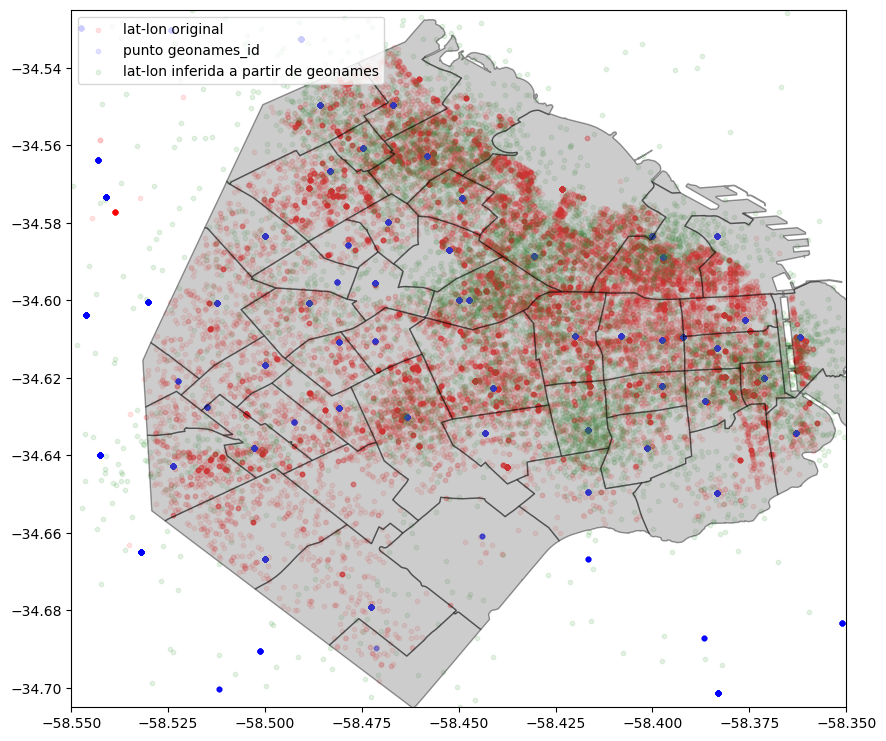

In [186]:
# Ubicamos los puntos en el mapa para ver si se distribuyen de forma uniforme.

# Estos df ya fueron creado y están puestos como referencia
# geo_location_data_gdf = gpd.GeoDataFrame(geo_location_data, geometry=gpd.points_from_xy(geo_location_data.lon, geo_location_data.lat))
# geo_location_data_gdf_capital = geo_location_data_gdf[data['state_name']=='Capital Federal']
data_clean_location_capital = data_clean_location[data_clean_location['state_name']=='Capital Federal']

geo_location_data_gdf_capital_geonames_norm = gpd.GeoDataFrame(data_clean_location_capital, geometry=gpd.points_from_xy(data_clean_location_capital.lon_inferred, data_clean_location_capital.lat_inferred))
df_barrios_capital = pd.read_csv('./data/barrios.csv', sep=',', encoding='latin-1')


df_barrios_capital["WKT"] = df_barrios_capital["WKT"].apply(shapely.wkt.loads) 
df_barrios_capital = gpd.GeoDataFrame(df_barrios_capital, geometry='WKT')

fig, ax = plt.subplots(figsize=(10,20))

geo_location_data_gdf_capital.plot(ax=ax, markersize=10, color='red', alpha=0.1) 
geo_location_data_gdf_geonames.plot(ax=ax, markersize=10, color='blue', alpha=0.1)
geo_location_data_gdf_capital_geonames_norm.plot(ax=ax, markersize=10, color='green', alpha=0.1)
df_barrios_capital.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
plt.xlim(-58.55,-58.350)
plt.ylim(-34.705,-34.525) 
plt.legend(['lat-lon original', 'punto geonames_id', 'lat-lon inferida a partir de geonames'], loc='upper left')
plt.show()

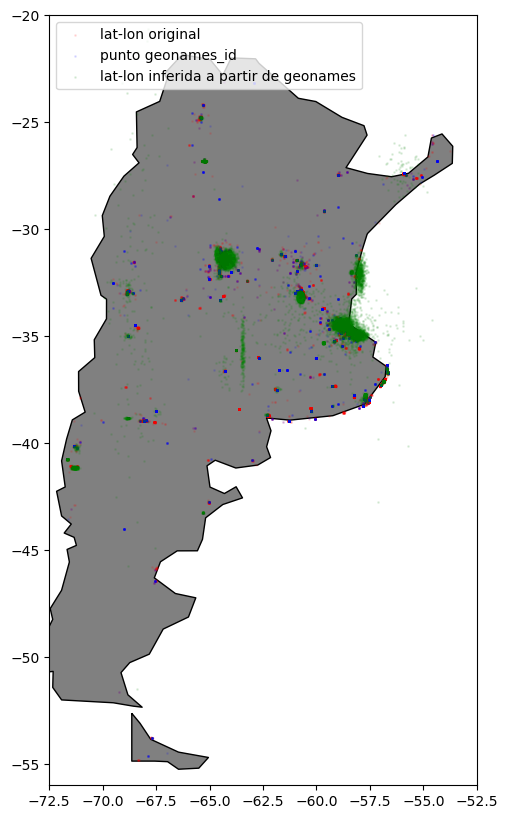

In [187]:
# Vemos las propiedades en el mapa de Argentina
argentina = world[world['name'] == 'Argentina']
geo_location_data_gdf_norm = gpd.GeoDataFrame(data_clean_location, geometry=gpd.points_from_xy(data_clean_location.lon_inferred, data_clean_location.lat_inferred)) 
fig, ax = plt.subplots(figsize=(10,10))
argentina.plot(ax=ax, color='grey', edgecolor='black')
data_clean_location_gdf = gpd.GeoDataFrame(geo_location_data_gdf, geometry='geometry')
data_clean_location_gdf.plot( markersize=1, color='red', alpha=0.1,ax=ax)
geo_location_data_gdf_geonames.plot(ax=ax, markersize=1, color='blue', alpha=0.1)
geo_location_data_gdf_norm.plot( markersize=1, color='green', alpha=0.1,ax=ax)
plt.legend(['lat-lon original', 'punto geonames_id', 'lat-lon inferida a partir de geonames'], loc='upper left')
plt.xlim(-72.5,-52.5)
plt.ylim(-56,-20)
plt.show()


> Conclusión: 
> - Imputar place_name a partir de la información recolectada en places_with_parent_names es bastante preciso.
> - Imputar lat y lon a partir de geonames_id es bastante más complicado y habría que ver cómo interactúa con el modelo. Si bien consideramos que vale la pena probarlo, sin mayor información no lo consideramos prudente para agregarlo al dataset
> ___

In [188]:
# Después de mucho analizar, decidimos que la mejor forma de imputar los valores de lat y lon 
# es no imputarlos, ya que no se puede inferir de forma correcta la ubicación de las propiedades a 
# través de los datos de geonames.
# Recreo el df con los datos originales

data_clean_location = data_clean_location[geolocation+ ['place_name', 'state_name']]
data_clean_location = gpd.GeoDataFrame(data_clean_location, geometry=gpd.points_from_xy(data_clean_location.lon, data_clean_location.lat))
data_ubicacion_limpia = data_clean_location[['place_name','state_name', 'geometry', 'lat', 'lon']].copy()
data_ubicacion_limpia

,place_name,state_name,geometry,lat,lon
0,Mataderos,Capital Federal,POINT (-58.50884 -34.66182),-34.661824,-58.508839
1,La Plata,Bs.As. G.B.A. Zona Sur,POINT (-57.96433 -34.90388),-34.903883,-57.964330
2,Mataderos,Capital Federal,POINT (-58.52298 -34.65226),-34.652262,-58.522982
3,Liniers,Capital Federal,POINT (-58.51642 -34.64780),-34.647797,-58.516424
5,Gualeguaychú,Entre Ríos,POINT (-58.51983 -33.01407),-33.014071,-58.519828
...,...,...,...,...,...
121213,San Isidro,Bs.As. G.B.A. Zona Norte,POINT EMPTY,NaN,NaN
121214,San Isidro,Bs.As. G.B.A. Zona Norte,POINT EMPTY,NaN,NaN
121215,Belgrano,Capital Federal,POINT EMPTY,NaN,NaN
121216,San Isidro,Bs.As. G.B.A. Zona Norte,POINT EMPTY,NaN,NaN


## Imputaciones Superficie

#### 1-se adicionan  la nueva columna "sup_m2_total_limpia" los datos obtenidos de la columna descripción.

In [189]:
#recordamos cuantos datos vacíos tiene la columna de interés.
data_superficie["surface_total_in_m2"].isnull().sum()

39328

In [190]:
data_superficie["sup_m2_total_limpia"] = data_superficie["surface_total_in_m2"].copy()
data_superficie["sup_m2_total_limpia"].fillna(data_superficie["Sup_m2_Clean_tres"],inplace=True)

In [191]:
print(data_superficie["sup_m2_total_limpia"].isnull().sum())
(1-(data_superficie["sup_m2_total_limpia"].isnull().sum()/data_superficie["surface_total_in_m2"].isnull().sum()))*100

27040


31.24491456468673

> luego de la imputación de los datos obtenidos por regex la columna disminuye el 31% sus valores nulos.
> ___

#### 2- Del análisis de consistencia de datos entre columnas de superficie total vs cubierta, se decide imputar los valores de superficie cubierta a la columna de superficie total, para valores de superficie total menor que superficie cubierta y donde superficie cubierta es menor a 1000m2

In [192]:
data_superficie.loc[mascara_coherencia_sup_menor,"sup_m2_total_limpia"] = data_superficie["surface_covered_in_m2"]

In [193]:
print(data_superficie["sup_m2_total_limpia"].isnull().sum())
(1-(data_superficie["sup_m2_total_limpia"].isnull().sum()/data_superficie["surface_total_in_m2"].isnull().sum()))*100

9111


76.83329943043124

> obteniendo una reducción del 78.9% de la información faltante
> ___

#### 3- Del análisis de las columnas donde existen outliers se detecta que los valores en superficie cubierta son mas coherentes por lo cual, se decide para estas 87 columnas imputar el valor superficie cubierta como superficie total

In [194]:
data_superficie.loc[mask_consistencia_outlier_sup,"sup_m2_total_limpia"] = data_superficie["surface_covered_in_m2"]

In [195]:
data_superficie["sup_m2_total_limpia"]=pd.to_numeric(data_superficie["sup_m2_total_limpia"])

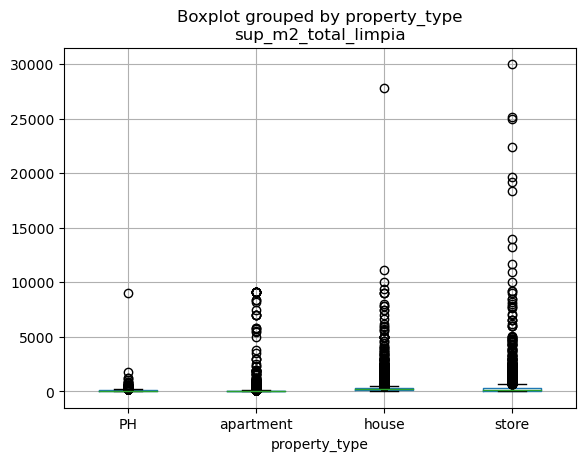

In [196]:
data_superficie.boxplot("sup_m2_total_limpia", by="property_type") 
plt.show()

In [197]:
outlier_value = 10000
mask_consistencia_outlier_sup_dos= data_superficie["sup_m2_total_limpia"] >= outlier_value
data[mask_consistencia_outlier_sup_dos].shape

(13, 25)

In [198]:
consistencia_outlier_sup_dos= data_superficie[mask_consistencia_outlier_sup_dos]
consistencia_outlier_sup_dos[["surface_total_in_m2","surface_covered_in_m2","sup_m2_total_limpia", "property_type","rooms","Sup_m2_Clean_tres"]]

,surface_total_in_m2,surface_covered_in_m2,sup_m2_total_limpia,property_type,rooms,Sup_m2_Clean_tres
17204,11111.0,11111.0,11111.0,house,NaN,NaN
44245,35195.0,27853.0,27853.0,house,NaN,30.0
65387,14000.0,14000.0,14000.0,store,NaN,14.0
66562,11680.0,11680.0,11680.0,store,NaN,11.0
67528,13200.0,13200.0,13200.0,store,NaN,11.0
67777,20000.0,19200.0,19200.0,store,NaN,20.0
67857,25000.0,25000.0,25000.0,store,NaN,NaN
68655,20500.0,19609.0,19609.0,store,NaN,25.0
69115,10958.0,10958.0,10958.0,store,NaN,151.0
85503,18375.0,18375.0,18375.0,store,NaN,10.0


#### 4- Se imputan los valores de superficie cubierta ajustados a los faltantes en superficie total

In [199]:
data_superficie = data_superficie.merge(fill_values_m2_df,on='property_type',suffixes=('','_median'),how='left')
data_superficie.sample(5)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,properati_url,description,title,image_thumbnail,Sup_m2_Clean,Sup_m2_Clean_dos,Sup_m2_Clean_tres,sup_m2_total_limpia,coef_ajuste_m2,coef_ajuste_m2_median
34020,sell,apartment,Villa Gesell,|Argentina|Buenos Aires Costa Atlántica|Villa ...,Argentina,Buenos Aires Costa Atlántica,3427431.0,"-37.2598939,-56.9714194",-37.259894,-56.971419,...,http://www.properati.com.ar/18b5v_venta_depart...,DEPARTAMENTO 1 AMBIENTE ZONA CENTRO PLAYA DEPA...,Departamento zona centro playa,https://thumbs4.properati.com/0/MXfybn1TrS6Xi1...,NaN,NaN,NaN,25.0,NaN,1.092593
34598,sell,house,Lanús Oeste,|Argentina|Bs.As. G.B.A. Zona Sur|Lanús|Lanús ...,Argentina,Bs.As. G.B.A. Zona Sur,NaN,"-34.6913386,-58.4220089",-34.691339,-58.422009,...,http://www.properati.com.ar/18c9g_venta_casa_l...,CODIGO: 3439-VF3500 ubicado en: PASAJE ROMERO ...,"CASA 3 AMBIENTES BAJO PH IMPECABLE, APTA CREDITO.",https://thumbs4.properati.com/8/Fc82sHnZOWC7NJ...,NaN,NaN,NaN,NaN,NaN,1.250000
39515,sell,apartment,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Argentina,Capital Federal,3429760.0,"-34.5994676,-58.3646043",-34.599468,-58.364604,...,http://www.properati.com.ar/18oie_venta_depart...,"FORUM Venta de Departamento Puerto Madero, Ca...",DEPARTAMENTO EN VENTA,https://thumbs4.properati.com/1/FIVs9xOoEhsLUa...,90,90.0,90.0,92.0,1.0,1.092593
26629,sell,apartment,Boedo,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,3436003.0,"-34.619665,-58.416391",-34.619665,-58.416391,...,http://www.properati.com.ar/17rb6_venta_depart...,Departamento 1 ambiente divisible con balconD...,Depto 1 amb divisible con balcon en cuotas $ 1...,https://thumbs4.properati.com/8/nHFoHDAY1thO6J...,NaN,NaN,NaN,33.0,1.0,1.092593
88456,sell,apartment,San Roque,|Argentina|Mendoza|San Roque|,Argentina,Mendoza,3836586.0,NaN,NaN,NaN,...,http://www.properati.com.ar/1b7bh_venta_depart...,Departamento de gran confort de amplio dormito...,Departamento - Las Mercedes,https://thumbs4.properati.com/9/980RtRsJv-kaHx...,NaN,NaN,NaN,76.0,NaN,1.092593


In [200]:
#Relleno los nan del coef
data_superficie.coef_ajuste_m2.fillna(data_superficie.coef_ajuste_m2_median,inplace=True)

In [201]:
data_superficie['m2_total_ajust']=np.where(data_superficie['sup_m2_total_limpia'].isnull(),data_superficie['coef_ajuste_m2']*data_superficie['surface_covered_in_m2'],data_superficie['sup_m2_total_limpia'])

In [202]:
data_superficie.m2_total_ajust.notnull().sum()

112151

In [203]:
print(data_superficie.surface_covered_in_m2.notnull().sum()/data_superficie.shape[0])
print(data_superficie.m2_total_ajust.notnull().sum()/data_superficie.shape[0])

0.8357779244349117
0.9251856129351592


In [204]:
data_superficie_limpia = data_superficie['sup_m2_total_limpia'].copy()

> Se logra recuperar un 92% de información
> ___

## Imputación  Ambientes

#### 1- Imputación los datos obtenidos por regex

In [205]:
mask_amb_not_null=data_ambientes.Ambientes_Clean.notnull()
data_ambientes.loc[mask_amb_not_null,'Ambientes_Clean']=data_ambientes.loc[mask_amb_not_null,'Ambientes_Clean'].astype('int')

In [206]:
data_ambientes.Ambientes_Clean=data_ambientes.Ambientes_Clean.astype('Int64')

In [207]:
ambientes_non_null=data_ambientes.Ambientes_Clean[mask_amb_not_null]
metros_mask_amb_non_null=data_ambientes.surface_covered_in_m2[mask_amb_not_null]

In [208]:
data_ambientes.surface_covered_in_m2=data_ambientes.surface_covered_in_m2.astype('Int64')
data_ambientes[['Ambientes_Clean','surface_covered_in_m2']].dtypes

Ambientes_Clean          Int64
surface_covered_in_m2    Int64
dtype: object

In [209]:
data_ambientes['size_rooms']=np.where(data_ambientes['Ambientes_Clean'].notnull(),data_ambientes['surface_covered_in_m2']/data_ambientes['Ambientes_Clean'],np.NaN)

In [210]:
data_ambientes[['Ambientes_Clean','surface_covered_in_m2','size_rooms']]

,Ambientes_Clean,surface_covered_in_m2,size_rooms
0,<NA>,40,NaN
1,<NA>,<NA>,NaN
2,<NA>,55,NaN
3,3,<NA>,NaN
4,<NA>,35,NaN
...,...,...,...
121215,<NA>,93,NaN
121216,<NA>,360,NaN
121217,1,39,39.0
121218,<NA>,48,NaN


 ##### 2- Imputación del tamaño mediano por tipo de propiedad

In [211]:
#Mergeamos los datos obtenidos con el df
data_ambientes = data_ambientes.merge(fill_values_df,on='property_type',suffixes=('','_median'),how='left')
data_ambientes.sample(10)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,floor,rooms,expenses,properati_url,description,title,image_thumbnail,Ambientes_Clean,size_rooms,size_rooms_median
23090,sell,apartment,Barracas,|Argentina|Capital Federal|Barracas|,Argentina,Capital Federal,3436134.0,"-34.6312534,-58.3715253",-34.631253,-58.371525,...,4.0,NaN,NaN,http://www.properati.com.ar/17kjm_venta_depart...,VENTA DEPARTAMENTO 2 AMBIENTES BARRACASSemipi...,DEPARTAMENTO EN VENTA,https://thumbs4.properati.com/3/t_PscjksqD_QE3...,2,22.5,26.0
118008,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,NaN,NaN,NaN,...,NaN,NaN,1.0,http://www.properati.com.ar/1ceaj_venta_depart...,"3 Ambientes.2 suites, living comedor, toilette...",Departamento - Belgrano,https://thumbs4.properati.com/7/RmygEC93qjkbAd...,<NA>,NaN,26.0
93790,sell,house,Villa Crespo,|Argentina|Capital Federal|Villa Crespo|,Argentina,Capital Federal,3427458.0,"-34.5931899213,-58.4345989529",-34.593190,-58.434599,...,NaN,NaN,NaN,http://www.properati.com.ar/1beo7_venta_casa_v...,Casa en 2 Plantas - Sobre lote de 7.54x9.02 - ...,Casa en Villa Crespo,https://thumbs4.properati.com/6/5cblrqbFuMIscK...,4,30.0,40.0
4688,sell,house,Bernal,|Argentina|Bs.As. G.B.A. Zona Sur|Quilmes|Bernal|,Argentina,Bs.As. G.B.A. Zona Sur,3436033.0,"-34.709188,-58.27229",-34.709188,-58.272290,...,NaN,NaN,NaN,http://www.properati.com.ar/15nhx_venta_casa_b...,CODIGO: 1697-lebens ubicado en: Lebensohn esq....,Chalet de 3 ambientes recién reciclado,https://thumbs4.properati.com/7/cXewcbEdXu1c8Q...,3,<NA>,40.0
57364,sell,apartment,Villa Luro,|Argentina|Capital Federal|Villa Luro|,Argentina,Capital Federal,3427407.0,"-34.639195,-58.515412",-34.639195,-58.515412,...,NaN,2.0,NaN,http://www.properati.com.ar/19snt_venta_depart...,"Espectacular departamento 2 ambientes, a estre...","Espectacular dpto.2 amb.a estrenar, fte. balcó...",https://thumbs4.properati.com/7/VulTPrtnZZVpyi...,2,<NA>,26.0
18176,sell,house,Los Hornos,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|Los...,Argentina,Bs.As. G.B.A. Zona Sur,NaN,"-34.9639056911,-57.9887562823",-34.963906,-57.988756,...,NaN,NaN,NaN,http://www.properati.com.ar/175ib_venta_casa_l...,casa de dos dormitorios desarrollada sobre un ...,casa 2 dormitos los hornso,https://thumbs4.properati.com/8/tKHWHndztIwGo6...,<NA>,NaN,40.0
25289,sell,house,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,"-32.9874753,-60.6402467",-32.987475,-60.640247,...,NaN,5.0,NaN,http://www.properati.com.ar/17puh_venta_casa_r...,Rosario: Garibaldi 533 Dto 2: Departamento Int...,"Duplex en Venta en Rosario, Garibaldi 533,",https://thumbs4.properati.com/5/pHR5tqTHGv_AdP...,5,13.0,40.0
108350,sell,apartment,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,http://www.properati.com.ar/1bzxq_venta_depart...,Espectacular departamento con terraza y una vi...,Departamento - Miradores de la Bahia,https://thumbs4.properati.com/0/AMQy9uNwG7v_zG...,<NA>,NaN,26.0
19063,sell,house,Barrio San Isidro Labrador,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Barr...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.382765,-58.681599",-34.382765,-58.681599,...,NaN,6.0,NaN,http://www.properati.com.ar/178oa_venta_casa_b...,Corredor Responsable: Mauro Marvisi - CMCPSI 5...,CASA MUY LINDA EN SAN ISIDRO LABRADOR,https://thumbs4.properati.com/2/3Tq7v69wi3YCC-...,6,33.333333,40.0
115660,sell,apartment,Córdoba,|Argentina|Córdoba|Córdoba|,Argentina,Córdoba,3860259.0,NaN,NaN,NaN,...,NaN,NaN,NaN,http://www.properati.com.ar/1cbg3_venta_depart...,"3 dorm, 1 baño, Cocina separada, Expensas baja...",Vendo Excepcional Depto. 3 Dorm. en San Vicent...,https://thumbs4.properati.com/0/F0lfZ4LBCXOqek...,<NA>,NaN,26.0


In [212]:
data_ambientes.size_rooms.fillna(data_ambientes.size_rooms_median,inplace=True)

In [213]:
mask_ambientes_null=data_ambientes.Ambientes_Clean.isnull()

In [214]:
data_ambientes['ambientes_2']=data_ambientes.surface_covered_in_m2/data_ambientes.size_rooms
#data_ambientes['ambientes_2']=data_ambientes['ambientes_2'].astype('Int64')
data_ambientes['ambientes_2'].dtype
data_ambientes['Ambientes_Clean']=data_ambientes['Ambientes_Clean'].astype('float64')
data_ambientes['Ambientes_Clean'].dtype
data_ambientes.Ambientes_Clean.fillna(data_ambientes.ambientes_2,inplace=True)


In [215]:
print(data_ambientes.Ambientes_Clean.notnull().sum()/data_ambientes.shape[0])
print(data_ambientes.rooms.notnull().sum()/data_ambientes.shape[0])

0.9079607325523841
0.3909420887642303


> Se logró imputar el 90% de Rooms!!! Si reemplazamos los m2_covered por los m2 imputados podemos lograr el 90%
> ____

In [216]:
#se colocan los datos de ambientes como categoricos
data_ambientes['Ambientes_Clean']=np.floor(pd.to_numeric(data_ambientes['Ambientes_Clean'], errors='coerce')).astype('Int64')

In [217]:
data_ambientes.Ambientes_Clean.value_counts()

2      25415
1      24303
3      23280
4      14695
5       8397
       ...  
339        1
173        1
76         1
103        1
300        1
Name: Ambientes_Clean, Length: 117, dtype: Int64

In [218]:
ambs_not_null_mask=data_ambientes['Ambientes_Clean'].notnull()

In [219]:
data_ambientes['ambiente_categorico']=data_ambientes.loc[ambs_not_null_mask,'Ambientes_Clean'].apply(lambda x: x if x < 4 else '4 o mas')

In [220]:
data_ambientes.ambiente_categorico.value_counts()

4 o mas    35618
2          25415
1          24303
3          23280
0           1447
Name: ambiente_categorico, dtype: int64

In [221]:
data_ambientes_categorico = data_ambientes['ambiente_categorico'].copy()

## Imputaciones Precio

#### 1- Imputación de información obtenida a través de regex

In [222]:
data_precio["precio_usd_limpio"]=data_precio["price_aprox_usd"]
data_precio["precio_usd_limpio"].fillna(data_precio["usd_clean_dos"],inplace=True)
data_precio["precio_usd_limpio"].isnull().sum()

20166

In [223]:
(1-data_precio["precio_usd_limpio"].isnull().sum()/data["price_aprox_usd"].isnull().sum())*100

1.1954924056834848

> Se recuperó el 1.2% de la información de precios en dólares del campo descripción. La recuperación de datos no es significativa.
> ___ 

####  2- Imputación a columna precios el valor del precio mediano por tipo de propiedad

In [224]:
data_precio["price_aprox_usd"].isnull().sum()

20410

In [225]:
# Agrupo las propiedades por tipo de propiedad y calculo el precio de la mediana
price_by_property = data_precio.groupby('property_type')['price_aprox_usd'].median()
price_by_property

property_type
PH           120000.0
apartment    119000.0
house        240000.0
store        210000.0
Name: price_aprox_usd, dtype: float64

In [226]:
# Agrupo las propiedades por tipo de propiedad y calculo el precio de la mediana
price_by_place_name = data_precio.groupby('place_name')['price_aprox_usd'].median()
price_by_place_name

place_name
 Country Maschwitz Club    320000.000
 los alamos                 81600.000
9 de Abril                 300000.000
Abasto                     135000.000
Abril Club de Campo        780000.000
                              ...    
Yerba Buena                167434.905
Zelaya                     125000.000
Zárate                     255000.000
coordenadas 34.255511      550000.000
Álvarez                           NaN
Name: price_aprox_usd, Length: 1060, dtype: float64

In [227]:
# Calculo la proporción de los precios de las propiedades por tipo de propiedad
price_by_property = price_by_property / price_by_property.sum()
price_by_property

property_type
PH           0.174165
apartment    0.172714
house        0.348331
store        0.304790
Name: price_aprox_usd, dtype: float64

In [228]:
# Ajusto el precio por propiedad en base a la mediana del precio por ubicación 
data_precio['price_usd_by_place_name'] = data_precio['place_name'].map(price_by_place_name)
data_precio['price_usd_by_property_type'] = data_precio['property_type'].map(price_by_property)
data_precio['price_usd_adjusted'] = data_precio['price_usd_by_place_name'] * data_precio['price_usd_by_property_type']
data_precio['price_usd_adjusted'].isnull().sum()


194

In [229]:
data_precio_null_init = data_precio["price_aprox_usd"].isnull().sum()
data_precio_null_init

20410

In [230]:
data_precio["price_aprox_usd"].fillna(data_precio["price_usd_adjusted"],inplace=True)

In [231]:
data_precio_null_end = data_precio["price_aprox_usd"].isnull().sum()
data_precio_null_end

171

In [232]:
# % de datos nulos que se completaron
(1-data_precio_null_end/data_precio_null_init)*100

99.16217540421363

> Se recupera el 99% de la información faltante 
> ___

In [233]:
# % de datos nulos restantes
data_precio_null_end/data_precio.shape[0]*100

0.14106583072100312

> queda el 0.14% de la columna con faltantes.
> ___

In [234]:
data_precio_limpia = data_precio['precio_usd_limpio'].copy()
data_precio_limpia

0          62000.0
1         150000.0
2          72000.0
3          95000.0
4          64000.0
            ...   
121215    870000.0
121216    498000.0
121217    131500.0
121218     95900.0
121219    129000.0
Name: precio_usd_limpio, Length: 121220, dtype: object

# Refinar los datos

In [235]:
# Juntamos los dataframes limpios de ubicación, geolocalización, superficie y precio
data_limpio = pd.concat([data_ubicacion_limpia, data_superficie_limpia, data_precio_limpia, data['property_type'], data_ambientes_categorico], axis=1)
print(data_limpio.shape)
data_limpio.head()

(121220, 9)


,place_name,state_name,geometry,lat,lon,sup_m2_total_limpia,precio_usd_limpio,property_type,ambiente_categorico
0,Mataderos,Capital Federal,POINT (-58.50884 -34.66182),-34.661824,-58.508839,40.0,62000.0,PH,1
1,La Plata,Bs.As. G.B.A. Zona Sur,POINT (-57.96433 -34.90388),-34.903883,-57.964330,NaN,150000.0,apartment,NaN
2,Mataderos,Capital Federal,POINT (-58.52298 -34.65226),-34.652262,-58.522982,55.0,72000.0,apartment,2
3,Liniers,Capital Federal,POINT (-58.51642 -34.64780),-34.647797,-58.516424,NaN,95000.0,PH,3
5,Gualeguaychú,Entre Ríos,POINT (-58.51983 -33.01407),-33.014071,-58.519828,53.0,NaN,house,NaN


In [236]:
# nos quedamos con las columnas que nos interesan
data_limpio = data_limpio[["place_name", "state_name", "lat", "lon", "sup_m2_total_limpia", "precio_usd_limpio", "property_type", "ambiente_categorico"]]
data_limpio.columns

Index(['place_name', 'state_name', 'lat', 'lon', 'sup_m2_total_limpia',
       'precio_usd_limpio', 'property_type', 'ambiente_categorico'],
      dtype='object')

In [237]:
# eliminamos todos los valores que quedaron con Nan en place_name, state_name, sup_m2_total_limpia, precio_usd_limpio
data_limpio.dropna(subset=['place_name', 'state_name', 'sup_m2_total_limpia', 'precio_usd_limpio'], inplace=True)
print(data_limpio.shape)
data_limpio.head()

(75173, 8)


,place_name,state_name,lat,lon,sup_m2_total_limpia,precio_usd_limpio,property_type,ambiente_categorico
0,Mataderos,Capital Federal,-34.661824,-58.508839,40.0,62000.0,PH,1
2,Mataderos,Capital Federal,-34.652262,-58.522982,55.0,72000.0,apartment,2
6,Vicente López,Bs.As. G.B.A. Zona Norte,-34.532957,-58.521782,78.0,130000.0,PH,3
7,Belgrano,Capital Federal,-34.559873,-58.443362,40.0,138000.0,apartment,1
8,Belgrano,Capital Federal,-34.559873,-58.443362,60.0,195000.0,apartment,2


In [238]:
# convertimos a float precio_usd_limpio
data_limpio['precio_usd_limpio'] = data_limpio['precio_usd_limpio'].astype(float)

In [239]:
# reenombramos las columnas 
data_limpio.rename(columns={'place_name': 'municipio', 'state_name': 'provincia', 'sup_m2_total_limpia': 'sup_m2_total', 'precio_usd_limpio': 'precio_usd','property_type': 'tipo', 'ambiente_categorico': "ambientes_cat"}, inplace=True)

In [240]:
data_limpio.dtypes

municipio         object
provincia         object
lat              float64
lon              float64
sup_m2_total     float64
precio_usd       float64
tipo              object
ambientes_cat     object
dtype: object

In [241]:
data_limpio.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,lat,lon,sup_m2_total,precio_usd
count,45439.00,45439.00,75173.00,75173.00
mean,-34.77,-59.05,121.18,232877.34
std,1.85,2.06,290.88,340115.41
min,-54.82,-71.67,0.00,10.00
25%,-34.66,-58.58,43.00,88587.00
50%,-34.60,-58.46,70.00,140000.00
75%,-34.55,-58.39,140.00,258000.00
max,-23.14,-54.58,30000.00,19500000.00


<AxesSubplot:title={'center':'sup_m2_total'}, xlabel='tipo'>

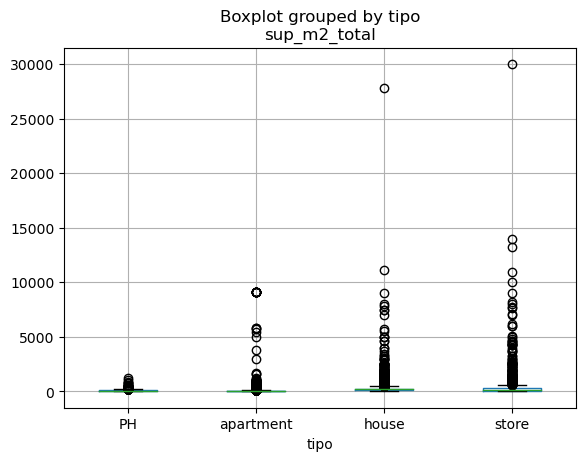

In [242]:
# Boxplot de superficie total por tipo de propiedad para ver si hay outliers
data_limpio.boxplot("sup_m2_total", by="tipo")

<AxesSubplot:title={'center':'precio_usd'}, xlabel='tipo'>

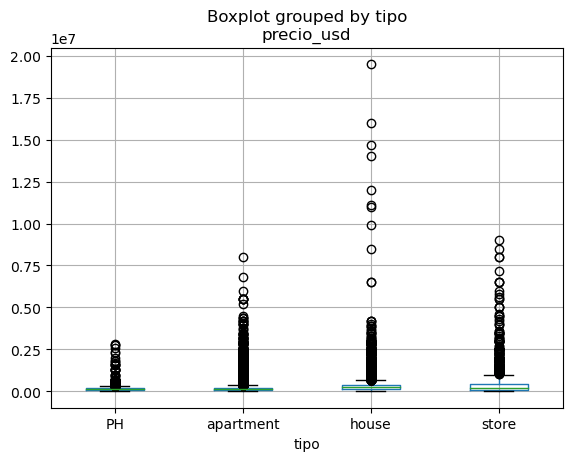

In [243]:
# Boxplot de precio por tipo de propiedad para ver si hay outliers
data_limpio.boxplot("precio_usd", by="tipo")


In [244]:
# creamos una columna con el precio por m2
data_limpio['precio_usd_por_m2'] = data_limpio['precio_usd'] / data_limpio['sup_m2_total']
print(data_limpio.shape)
data_limpio.head(3)

(75173, 9)


,municipio,provincia,lat,lon,sup_m2_total,precio_usd,tipo,ambientes_cat,precio_usd_por_m2
0,Mataderos,Capital Federal,-34.661824,-58.508839,40.0,62000.0,PH,1,1550.000000
2,Mataderos,Capital Federal,-34.652262,-58.522982,55.0,72000.0,apartment,2,1309.090909
6,Vicente López,Bs.As. G.B.A. Zona Norte,-34.532957,-58.521782,78.0,130000.0,PH,3,1666.666667


In [245]:
# Convierto las variables categóricas a numéricas
data_limpio['tipo'] = data_limpio['tipo'].astype('category')
data_limpio['tipo_cat_code'] = data_limpio['tipo'].cat.codes

data_limpio['municipio'] = data_limpio['municipio'].astype('category')
data_limpio['municipio_cat_code'] = data_limpio['municipio'].cat.codes

data_limpio['provincia'] = data_limpio['provincia'].astype('category')
data_limpio['provincia_cat_code'] = data_limpio['provincia'].cat.codes

data_limpio['ambientes_cat'] = data_limpio['ambientes_cat'].astype('category')
data_limpio['ambientes_cat_code'] = data_limpio['ambientes_cat'].cat.codes

print(data_limpio.shape)
data_limpio.head(3)

(75173, 13)


,municipio,provincia,lat,lon,sup_m2_total,precio_usd,tipo,ambientes_cat,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code
0,Mataderos,Capital Federal,-34.661824,-58.508839,40.0,62000.0,PH,1,1550.000000,0,194,5,1
2,Mataderos,Capital Federal,-34.652262,-58.522982,55.0,72000.0,apartment,2,1309.090909,1,194,5,2
6,Vicente López,Bs.As. G.B.A. Zona Norte,-34.532957,-58.521782,78.0,130000.0,PH,3,1666.666667,0,360,0,3


In [246]:
# Vemos la correlación entre las variables
data_limpio_corr = data_limpio.corr()
data_limpio_corr

,lat,lon,sup_m2_total,precio_usd,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code
lat,1.000000,-0.337869,0.029226,0.080660,0.019651,0.069120,0.034737,0.385454,-0.014569
lon,-0.337869,1.000000,-0.044330,-0.030629,-0.004350,-0.119501,-0.004221,-0.550445,0.011937
sup_m2_total,0.029226,-0.044330,1.000000,0.360638,-0.025709,0.235955,0.023789,-0.049224,0.151573
precio_usd,0.080660,-0.030629,0.360638,1.000000,0.150292,0.192521,0.046273,-0.081339,0.250199
precio_usd_por_m2,0.019651,-0.004350,-0.025709,0.150292,1.000000,0.008001,0.006096,-0.005892,-0.041721
tipo_cat_code,0.069120,-0.119501,0.235955,0.192521,0.008001,1.000000,0.030035,-0.079420,0.154103
municipio_cat_code,0.034737,-0.004221,0.023789,0.046273,0.006096,0.030035,1.000000,0.048376,0.033275
provincia_cat_code,0.385454,-0.550445,-0.049224,-0.081339,-0.005892,-0.079420,0.048376,1.000000,-0.190258
ambientes_cat_code,-0.014569,0.011937,0.151573,0.250199,-0.041721,0.154103,0.033275,-0.190258,1.000000


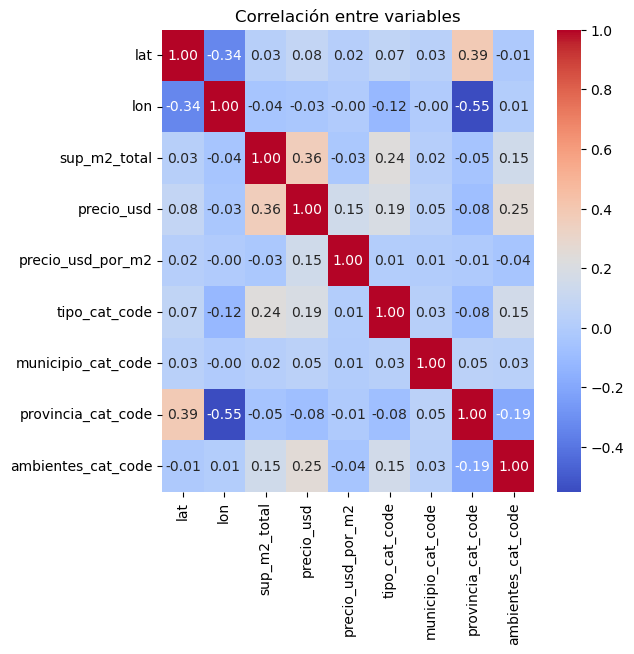

In [247]:
# Lo graficamos 
plt.figure(figsize=(6,6))
sns.heatmap(data_limpio_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlación entre variables")
plt.show()


c:\Users\LuisD\anaconda3\envs\dh\lib\site-packages\numpy\lib\function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


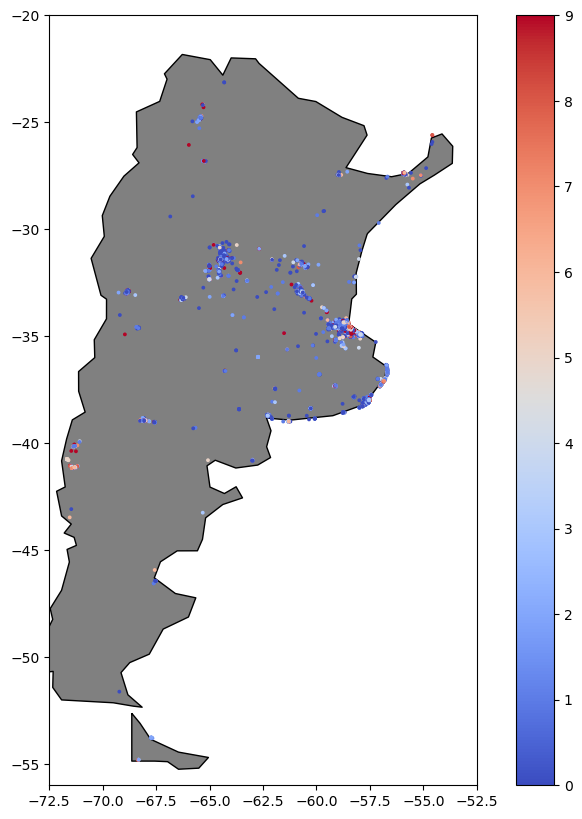

In [248]:
# Vemos un mapa de la Argentina con los precios por m2

# Agrego lat y lon para poder graficar 

# Convierto en geoDataFrame
data_limpio_gdf = gpd.GeoDataFrame(data_limpio, geometry=gpd.points_from_xy(data_limpio.lon, data_limpio.lat))

# Limpio los valores POINT EMPTY
data_limpio_gdf = data_limpio_gdf[~data_limpio_gdf.is_empty]

# Agrupo por precio por m2 en 10 categorías (percentiles)
data_limpio_gdf['precio_usd_por_m2_cat'] = pd.qcut(data_limpio_gdf['precio_usd_por_m2'], 10, labels=False)

argentina = world[world['name'] == 'Argentina']
fig, ax = plt.subplots(figsize=(10,10))
argentina.plot(ax=ax, color='grey', edgecolor='black')
data_limpio_gdf.plot( markersize=3, alpha=1,ax=ax, column='precio_usd_por_m2_cat', cmap='coolwarm', legend=True)
plt.xlim(-72.5,-52.5)
plt.ylim(-56,-20)
plt.show()

In [249]:
data_limpio_gdf = data_limpio_gdf[~data_limpio_gdf.is_empty]
data_limpio_gdf.sample(5)

,municipio,provincia,lat,lon,sup_m2_total,precio_usd,tipo,ambientes_cat,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code,geometry,precio_usd_por_m2_cat
9684,Mar del Plata,Buenos Aires Costa Atlántica,-38.008734,-57.537508,85.0,160000.0,apartment,4 o mas,1882.352941,1,188,3,4,POINT (-57.53751 -38.00873),4
2,Mataderos,Capital Federal,-34.652262,-58.522982,55.0,72000.0,apartment,2,1309.090909,1,194,5,2,POINT (-58.52298 -34.65226),2
60316,Balvanera,Capital Federal,-34.612352,-58.410189,71.0,139000.0,apartment,4 o mas,1957.746479,1,20,5,4,POINT (-58.41019 -34.61235),4
17784,Mar del Plata,Buenos Aires Costa Atlántica,-37.999315,-57.542541,85.0,169000.0,apartment,3,1988.235294,1,188,3,3,POINT (-57.54254 -37.99932),4
17160,Caballito,Capital Federal,-34.632654,-58.468637,41.0,102500.0,apartment,2,2500.000000,1,34,5,2,POINT (-58.46864 -34.63265),6


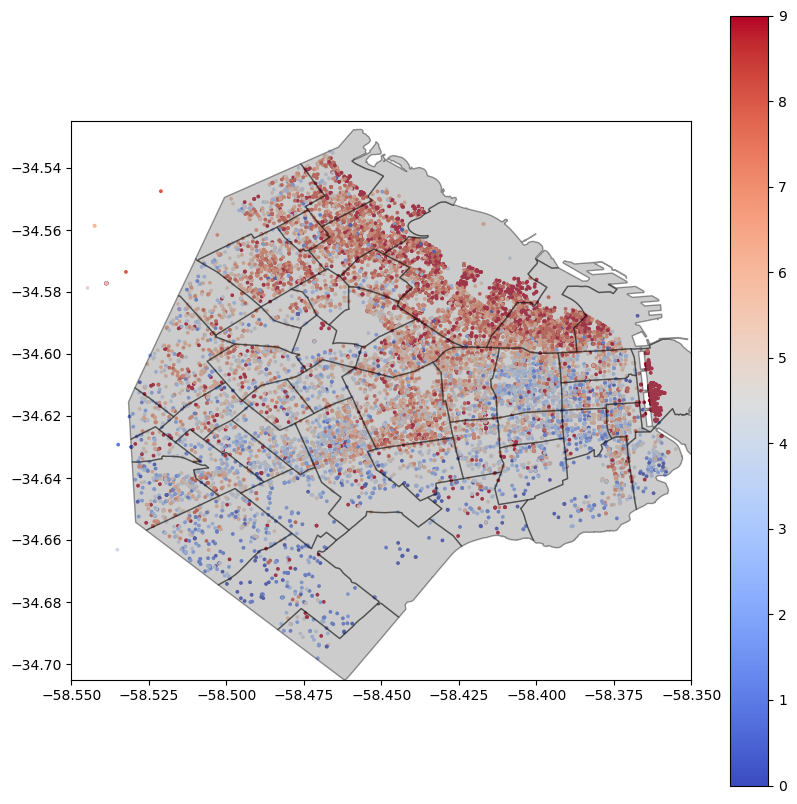

In [250]:
# Ubicamos los puntos en el mapa para ver si se distribuyen de forma uniforme.

# Estos df ya fueron creado y están puestos como referencia
# geo_location_data_gdf = gpd.GeoDataFrame(geo_location_data, geometry=gpd.points_from_xy(geo_location_data.lon, geo_location_data.lat))
# geo_location_data_gdf_capital = geo_location_data_gdf[data['state_name']=='Capital Federal']
data_clean_location_capital = data_clean_location[data_clean_location['state_name']=='Capital Federal']

df_barrios_capital = pd.read_csv('./data/barrios.csv', sep=',', encoding='latin-1')
data_limpio_gdf_capital = data_limpio_gdf[data_limpio_gdf['provincia']=='Capital Federal']

df_barrios_capital["WKT"] = df_barrios_capital["WKT"].apply(shapely.wkt.loads) 
df_barrios_capital = gpd.GeoDataFrame(df_barrios_capital, geometry='WKT')

fig, ax = plt.subplots(figsize=(10,10))


data_limpio_gdf_capital.plot( markersize=3, alpha=1,ax=ax, column='precio_usd_por_m2_cat', cmap='coolwarm', legend=True)
df_barrios_capital.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
plt.xlim(-58.55,-58.350)
plt.ylim(-34.705,-34.525)  
plt.show()

In [251]:
data_limpio_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 45439 entries, 0 to 121217
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   municipio              45439 non-null  category
 1   provincia              45439 non-null  category
 2   lat                    45439 non-null  float64 
 3   lon                    45439 non-null  float64 
 4   sup_m2_total           45439 non-null  float64 
 5   precio_usd             45439 non-null  float64 
 6   tipo                   45439 non-null  category
 7   ambientes_cat          44191 non-null  category
 8   precio_usd_por_m2      45439 non-null  float64 
 9   tipo_cat_code          45439 non-null  int8    
 10  municipio_cat_code     45439 non-null  int16   
 11  provincia_cat_code     45439 non-null  int8    
 12  ambientes_cat_code     45439 non-null  int8    
 13  geometry               45439 non-null  geometry
 14  precio_usd_por_m2_cat  45439 

In [252]:
missing_data = data_limpio_gdf.isna().sum(axis=0)
missing_data_df = pd.DataFrame(missing_data, columns=['total_nan'])
missing_data_df['perc_%'] = (missing_data_df / data.shape[0]).round(2)*100
missing_data_df.sort_values(ascending=False, by='total_nan')

,total_nan,perc_%
ambientes_cat,1248,1.0
municipio,0,0.0
provincia,0,0.0
lat,0,0.0
lon,0,0.0
sup_m2_total,0,0.0
precio_usd,0,0.0
tipo,0,0.0
precio_usd_por_m2,0,0.0
tipo_cat_code,0,0.0


# Conclusiones

- Tomaremos en cuenta la revision de outliers en superficie_m2_total y precio_m2 para la aplicación del modelo.
- Optimizamos el dataset original de 25 variables a 15 variables.
- Se logró mapear las propiedades en el mapa de Argentina corroborando la veracidad de ubicación de las propiedades.
- Logramos disminuir a un 0% los valores nan en 14 variables de nuestro dataset final. 

# Exportar el nuevo dataset 

In [253]:
data_limpio_gdf.to_csv('./data/data_limpio_gdf.csv', index=False)
